<!-- <span id='toc'/>

<h1 style="background:#05445E; border:0; border-radius: 12px; color:#D3D3D3"><center>TABLE OF CONTENTS</center></h1>

<ul class="list-group" style="list-style-type:none;">
    <li><a href="#0.0-IMPORTS" class="list-group-item list-group-item-action">0. Imports</a></li>
    <li><a href="#1.0-DATA-DESCRIPTION" class="list-group-item list-group-item-action">1. Data Description</a></li>
    <li><a href="#2.0-FEATURE-ENGINEERING" class="list-group-item list-group-item-action">2. Feature Engineering</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#3.1" class="list-group-item list-group-item-action">3.1 Exploratory Data Analysis</a></li>
            <li><a href="#3.2" class="list-group-item list-group-item-action">3.2 Dataset</a></li>
        </ul>
    </li>
    <li><a href="#4" class="list-group-item list-group-item-action">4. Model</a>
        <ul class="list-group" style="list-style-type:none;">
            <li><a href="#4.1" class="list-group-item list-group-item-action">4.1 Preprocessing Model</a></li>
            <li><a href="#4.2" class="list-group-item list-group-item-action">4.2 TabTransformer</a></li>
        </ul>
    </li>
    <li><a href="#5" class="list-group-item list-group-item-action">5. Training</a></li>
    <li><a href="#6" class="list-group-item list-group-item-action">6. Prediction</a></li>
</ul>
 -->

# 0.0 INTRO

## 0.1 Imports

In [2]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import pandas.io.sql         as sqlio
import psycopg2              as pg
import pickle
import os
import random
import kaggle

from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats
from matplotlib              import pylab



from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes     import GaussianNB

from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from catboost                import CatBoostClassifier



from sklearn.metrics         import precision_score, recall_score, accuracy_score,\
                                    balanced_accuracy_score,classification_report,roc_auc_score,\
                                    top_k_accuracy_score, roc_curve,auc,RocCurveDisplay,confusion_matrix, ConfusionMatrixDisplay


from skopt                   import forest_minimize
from skopt.plots             import plot_convergence

from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors       import KNeighborsClassifier


import warnings
warnings.filterwarnings("ignore")

## 0.2 Helper Functions

In [3]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1) / (n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
    
    return v

def cross_validation(model,x_train,y_train,k, verbose=True):
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    accuracy_balanced_list = []
    precision_k_list = [] 
    recall_k_list = []  
    auc_roc_list = []
    top_k_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_proba = model.predict_proba(x_val_fold)

        # Create data to make the precision and recall k
        data = pd.DataFrame()
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        data = data.sort_values('score',ascending=False)
        
        knum = y_val_fold.value_counts().count()-1
        
        # ROC AUC SCORE
        auc_roc = roc_auc_score(y_val_fold, yhat_proba[:, 1])
        auc_roc_list.append(auc_roc)
        
        # TOP K SCORE
        top_k = top_k_accuracy_score(y_val_fold,yhat_model,k=knum)
        top_k_list.append(top_k)
        
        # Balanced Accuracy
        accuracy_balanced = balanced_accuracy_score(y_val_fold,yhat_model)
        accuracy_balanced_list.append(accuracy_balanced)
        
        # Precision at K
        precision_k = precision_at_k(data,20000)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data,20000)
        recall_k_list.append(recall_k)
        i = i + 1
        
    df = pd.DataFrame({'Model Name': type(model).__name__,
                       'Accuracy Balanced': np.mean(accuracy_balanced_list),
                       'Precision @K Mean': np.mean(precision_k_list),
                       'Recall @K Mean': np.mean(recall_k_list),
                       'ROC AUC Score': np.mean(auc_roc_list),
                       'Top K Score': np.mean(top_k_list) },index = [0])
    return df    

def ranking_perfomance(model,x_val,y_validation,x_validation,k,rc=False):

    yhat_model = model.predict(x_val)
    yhat_model_proba = model.predict_proba(x_val)

    # Calculate the metrics

    # Top K Accuracy Score
    knum = y_validation.value_counts().count()-1
    top_k = top_k_accuracy_score(y_validation,yhat_model,k=knum)

    # AUC ROC
    auc_roc = roc_auc_score(y_validation, yhat_model_proba[:, 1])

    # Calculate Recall@K and Precision @K
    data = x_validation.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat_model_proba[:, 1].tolist()
    data = data.sort_values('score', ascending=False)

    recall_k_20000 = recall_at_k(data,k)
    precision_k_20000 = precision_at_k(data,k)
    
    if (rc == True):
        print('Recall at k = {}: {}'.format(k,recall_k_20000))
        print('Precision at k = {}: {}'.format(k,precision_k_20000))
    

    df = pd.DataFrame({'Model Name': type(model).__name__,
                       'ROC AUC': auc_roc, 
                       'Top @K Acc': top_k},index=[0])

    return df,yhat_model_proba

def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,height,'{:1.2f}%'.format(height/total*100),ha='center',weight='bold')

def diagnostic_plots(df, variable):
    # plot the histograms to have a quick look at the distributions
    # we can plot Q-Q plots to visualise if the variable is normally distributed
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
def jupyter_settings():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 18
    
    display()
    sns.set_theme(style="darkgrid", palette='hls')
    # sns.color_palette("crest", as_cmap=True)
    # sns.color_palette("magma", as_cmap=True)
    # sns.color_palette("flare", as_cmap=True)
    # Increase chart size for better readability
    sns.set(rc={'figure.figsize':(11,6)})


jupyter_settings()

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
)





## 0.3 Loading Dataset

### a) Train Data

In [4]:
# After SQL merge
df_raw = pd.read_csv('../data/raw/train.csv')
display(df_raw.head())

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### b) Test Data

In [5]:
# !kaggle datasets list -s anmolkumar/health-insurance-cross-sell-prediction
# !kaggle datasets
# !kaggle datasets download anmolkumar/health-insurance-cross-sell-prediction -f test.csv -p ./dataset/ --unzip
# !unzip dataset/test.csv.zip
# !mv test.csv ../data/raw/

# !rm -r dataset/

In [6]:
test = pd.read_csv('../data/raw/test.csv')
display(test.head())

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


# 1.0 DATA DESCRIPTION

In [13]:
df1 = df_raw.copy()

In [14]:
cols_new = [col.lower() for col in df1.columns]
df1.columns = cols_new
cols_test = [col_test.lower() for col_test in test.columns]
test.columns = cols_test

In [15]:
df1.columns, test.columns

(Index(['id', 'gender', 'age', 'driving_license', 'region_code',
        'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
        'policy_sales_channel', 'vintage', 'response'],
       dtype='object'),
 Index(['id', 'gender', 'age', 'driving_license', 'region_code',
        'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
        'policy_sales_channel', 'vintage'],
       dtype='object'))

### Columns Description

- **Id**: Customer identifier
- **Gender**: gender of customer
- **Age**: age of customer
- **Driving_License**: Customer has a license to drive or not
- **Region_Code**:	Unique code for the region of the customer
- **Previously_Insured**: Customer already had a Vehicle Insurance or not
- **Vehicle_Age**: Age of the Vehicle
- **Vehicle_Damage**: Customer got his/her vehicle damaged in the past or not
- **Annual_Premium**: The amount customer needs to pay as premium in the year
- **Policy Sales Channel**:	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- **Vintage**: Number of days a customer has been associated within the company
- **Response**:	Customer is interested or not in acquiring a vehicle insurance.

## 1.1 Data Dimension

In [26]:
display(f'Number of rows (clients): {df1.shape[0]}')
display(f'Number of columns (characteristics): {df1.shape[1]}')

'Number of rows (clients): 381109'

'Number of columns (characteristics): 12'

## 1.2 Data Types

In [27]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [28]:
df1.info()
# df1.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.4 Data Descriptive

In [29]:
# Separete numerical and categorical features
num_attributes = df1.select_dtypes(include='number')
cat_attributes = df1.select_dtypes(exclude='number')

In [30]:
print(num_attributes.shape[1])
print(cat_attributes.shape[1])

9
3


In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [32]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
describe_matrix = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
describe_matrix.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
describe_matrix

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 HYPOTHESIS CREATION

In [33]:
df2 = df1.copy()

### 2.1 Hypothesis Map

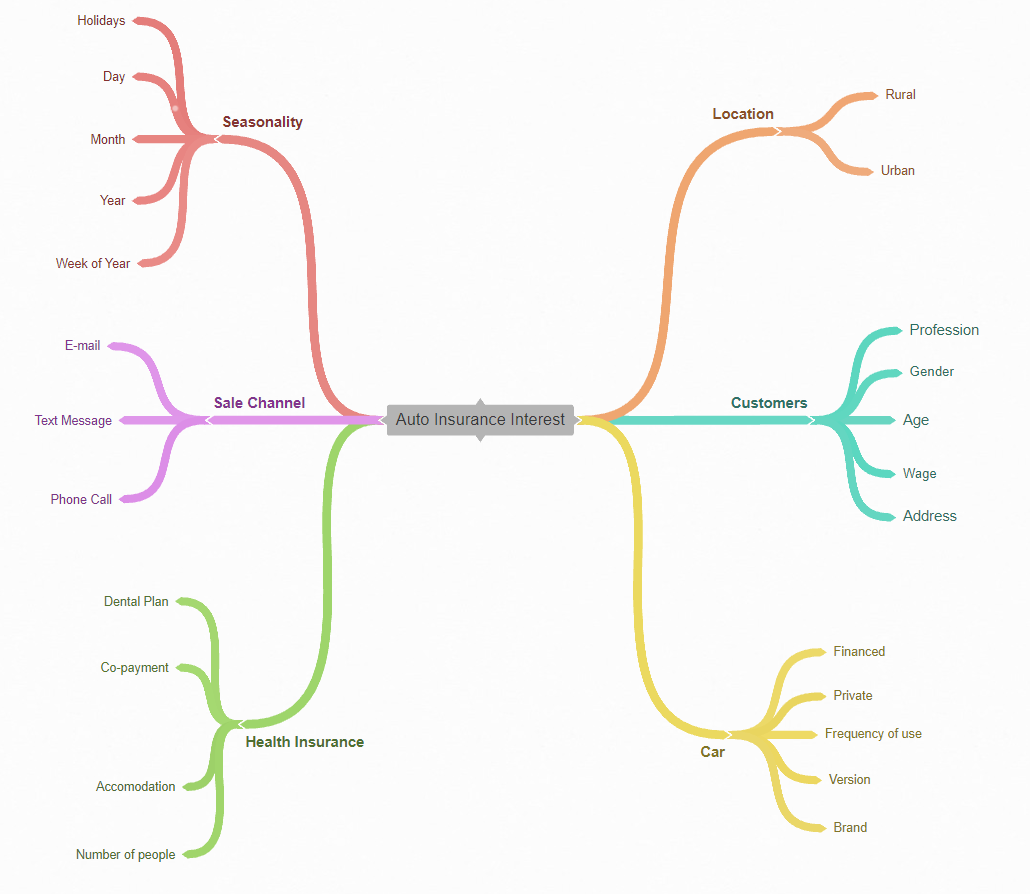

### 2.2 Hypothesis Brainstorm

- **Customers**:

    - H1. Greater interest in FEMALE CUSTOMERS.
    - H2. Greater interest in OVER 40 YO CUSTOMERS.
    
    
- **Location**:
    - H3. Greater interest in URBAN CUSTOMERS.
    
    
- **Health Insurance**:
    - H4. Greater interest in LONGER CUSTOMERS.
    
    
- **Auto Insurance**:
    - H5. Greater interest in customers who had VEHICLE PREVIOUSLY DAMAGED.
    - H6. Greater interest in customers who just bought a vehicle (vehicle age).
    

# 3.0 DATA FILTERING

In [34]:
df3 = df2.copy()

There was no feature or business related data requiring any filter maneuver looking at our Data Description.

# 4.0 EXPLORATORY DATA ANALYSIS

In [35]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [36]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

### 4.1.0 Sweetviz EDA

In [37]:
import sweetviz as sv
# Generate report
report = sv.analyze(df4, target_feat='response')

# Save and show on browser
# report.show_html(filepath='../reports/sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.

                                             |                | [  0%]   00:00 -> (? left)


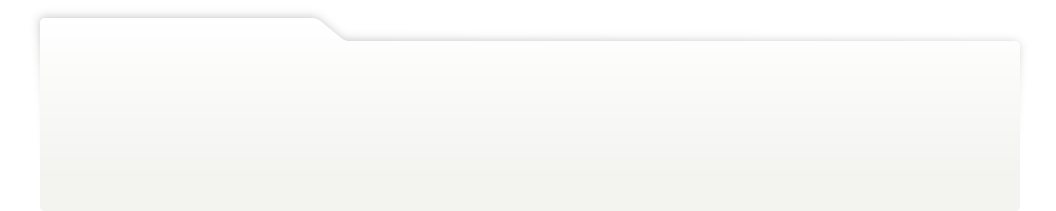
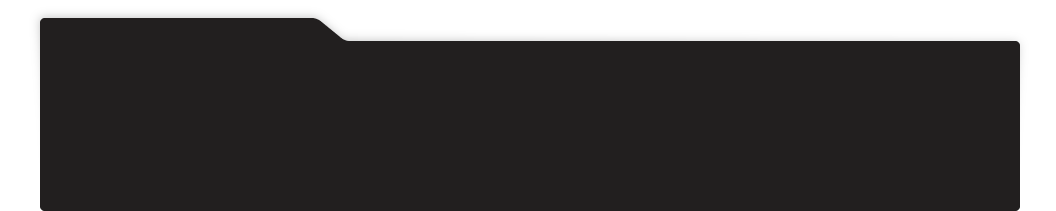
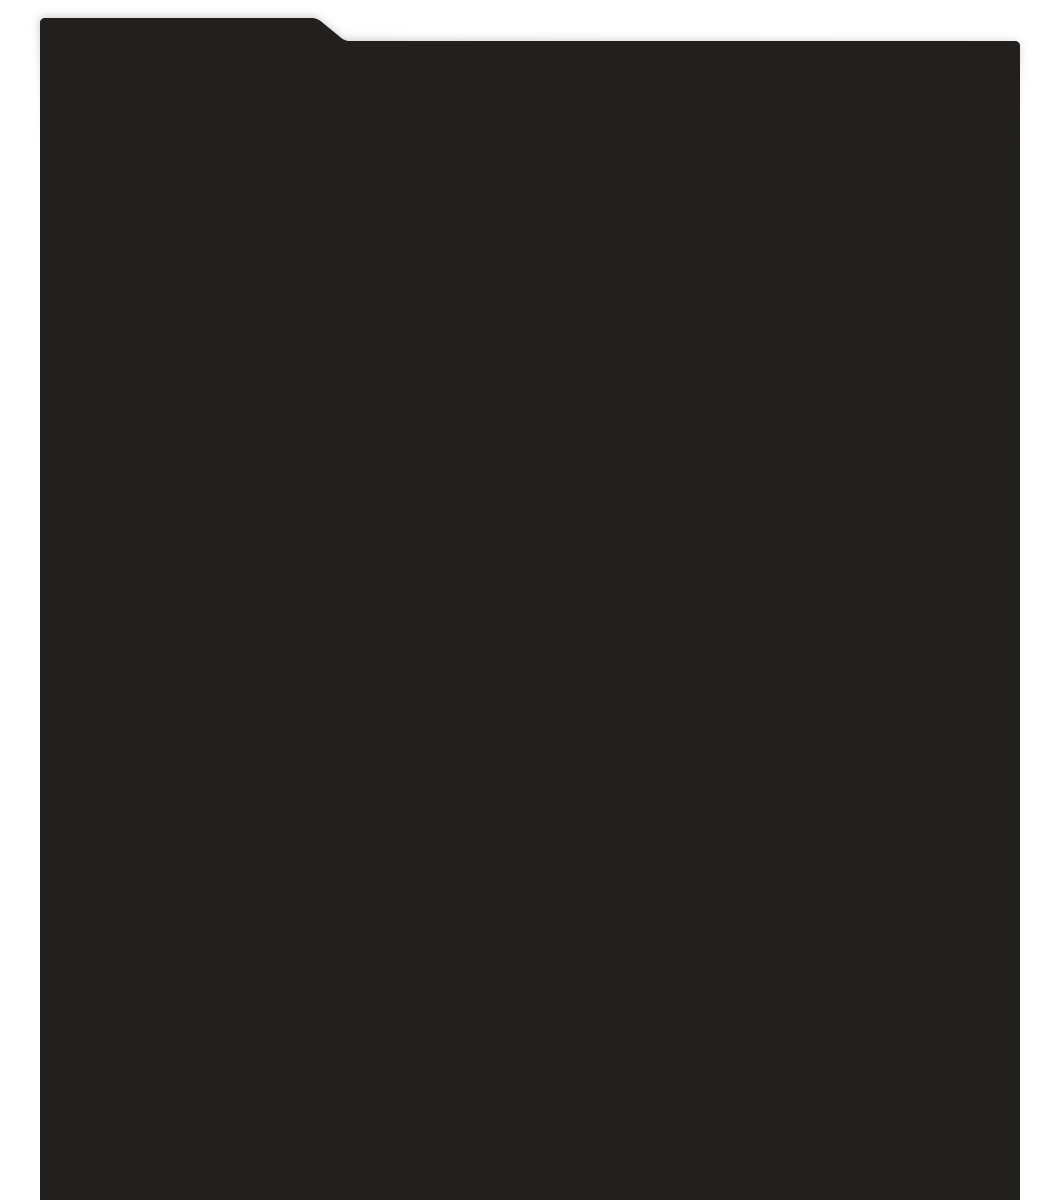
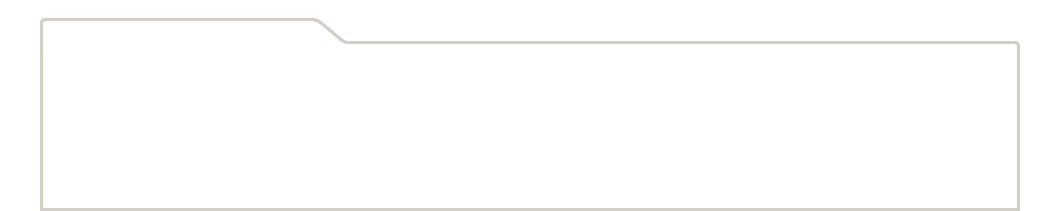
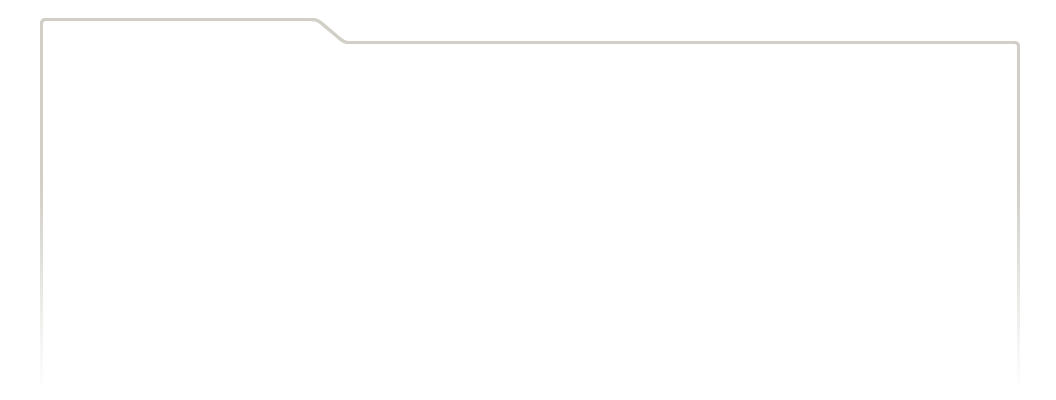
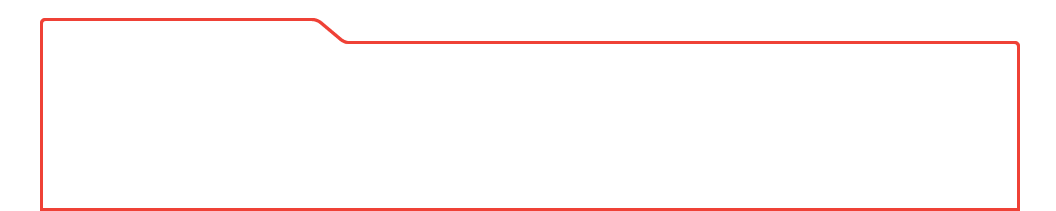
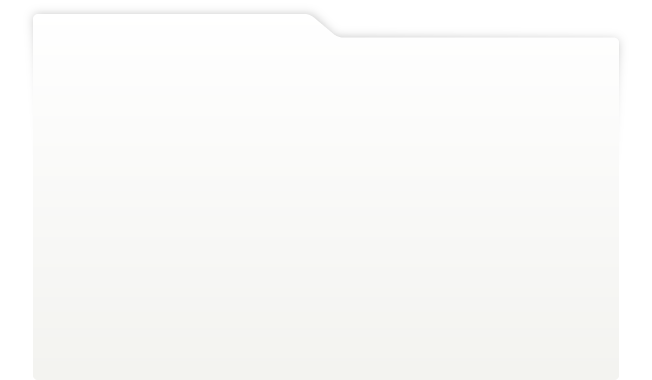
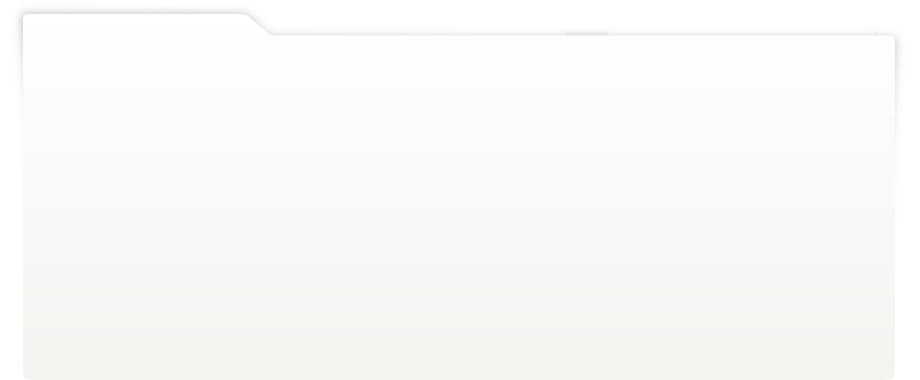
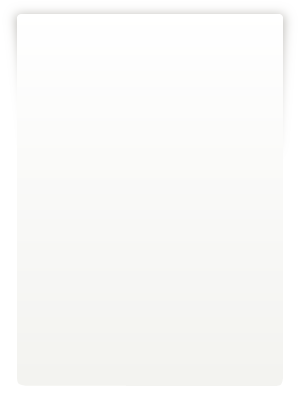
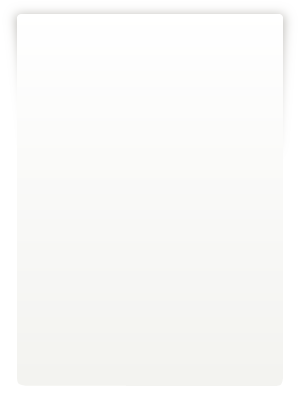
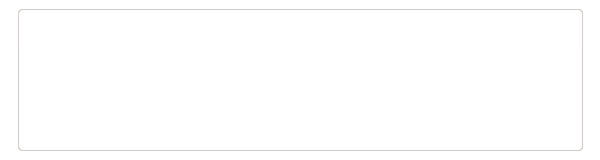
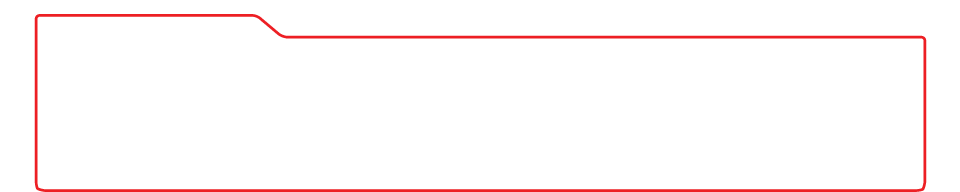
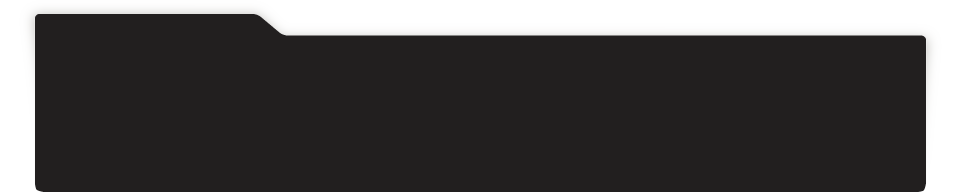
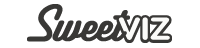
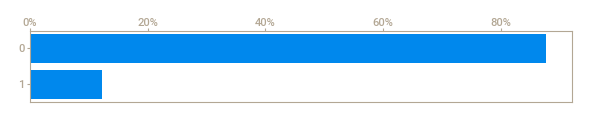
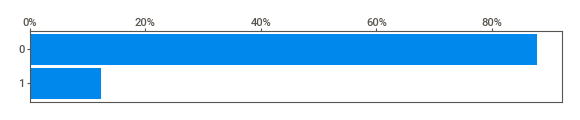
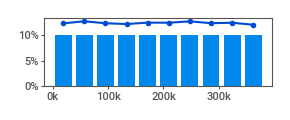
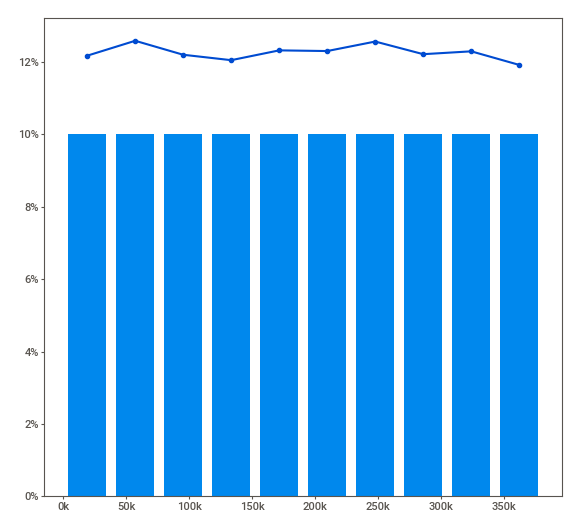
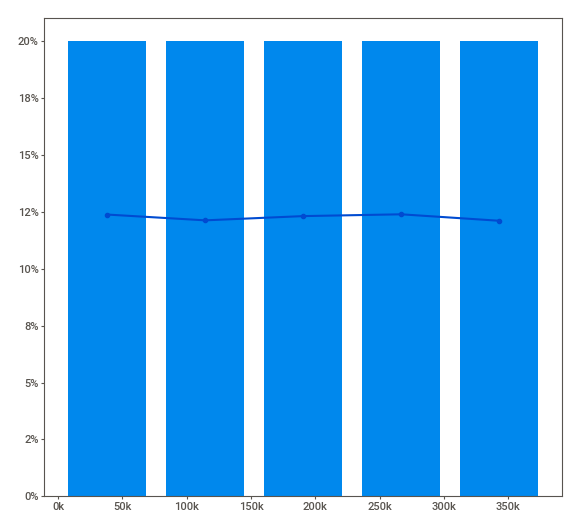
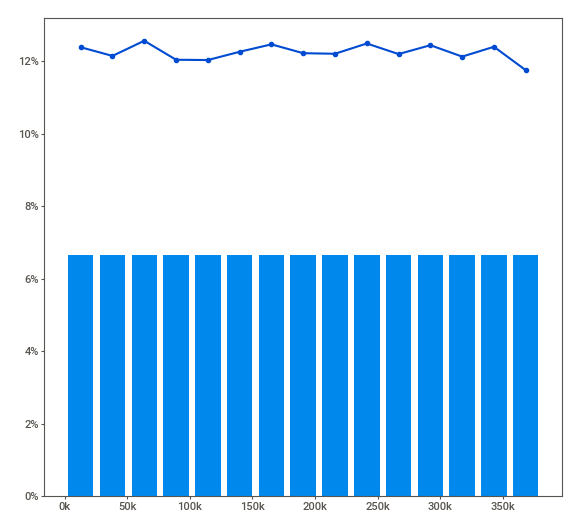
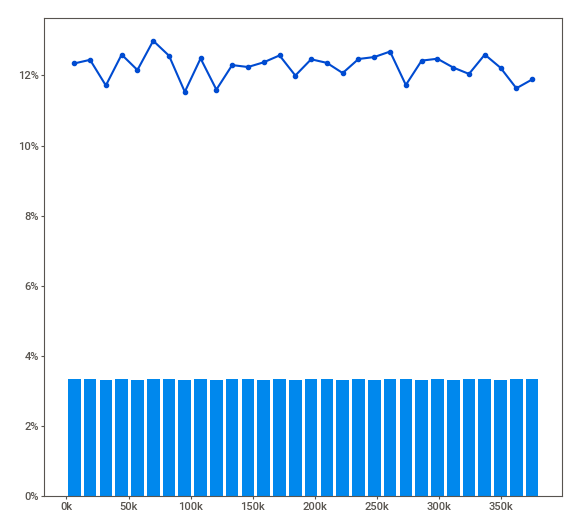
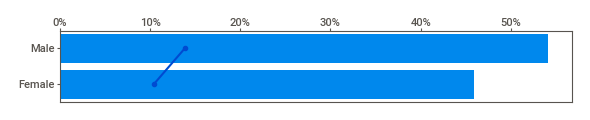
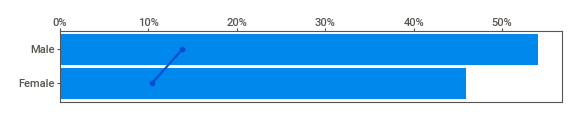
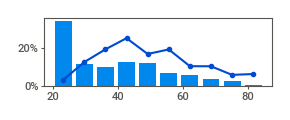
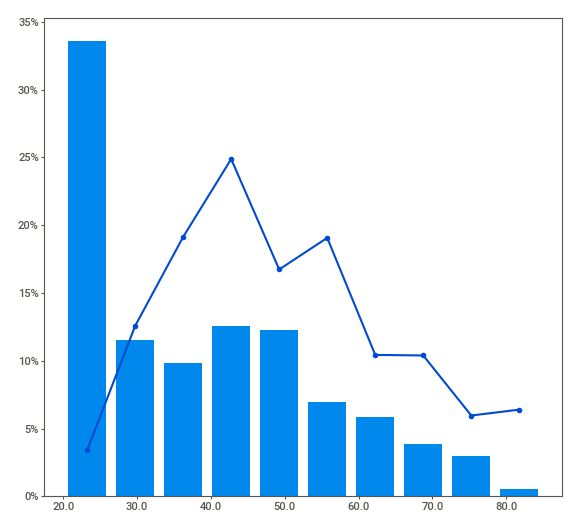
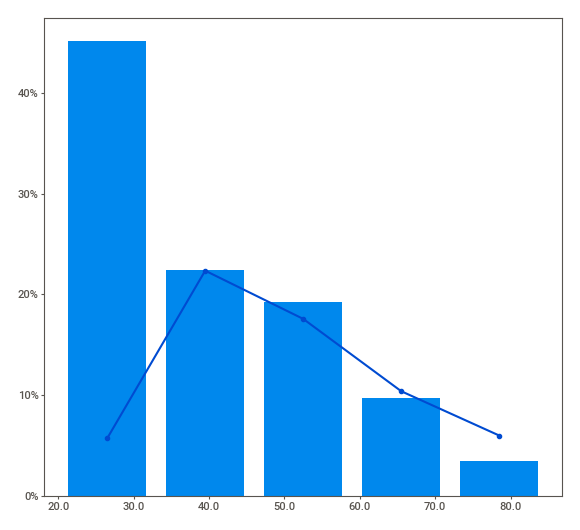
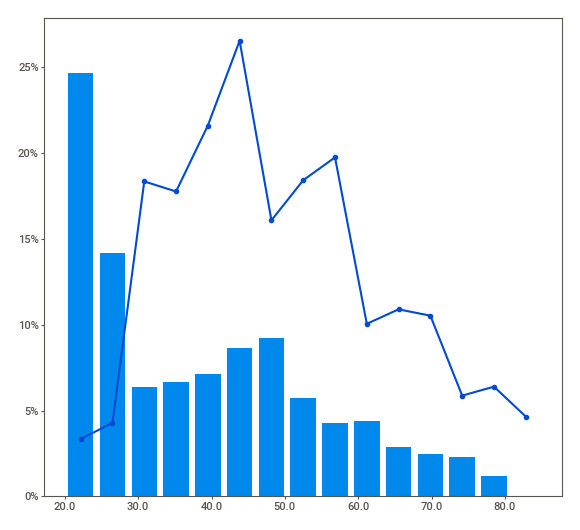
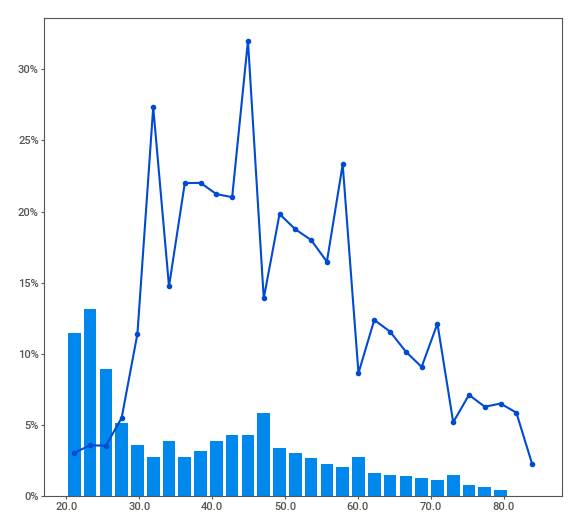
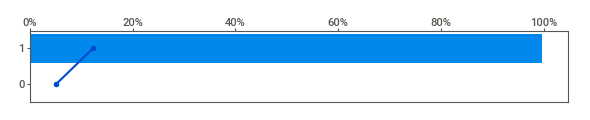
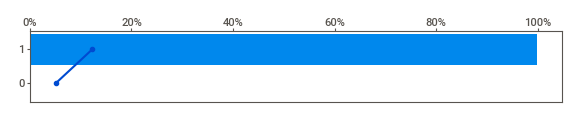
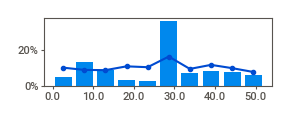
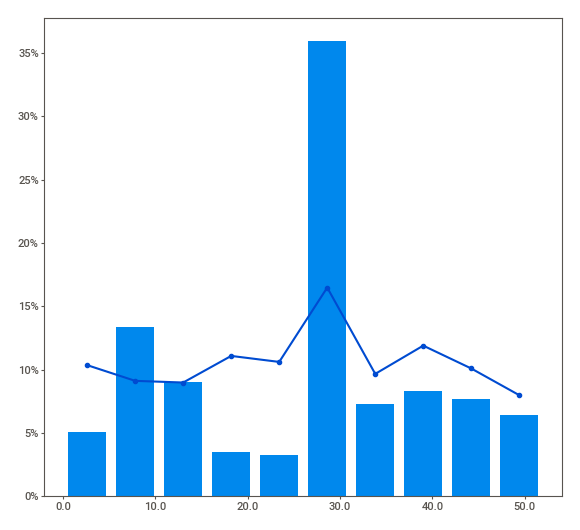
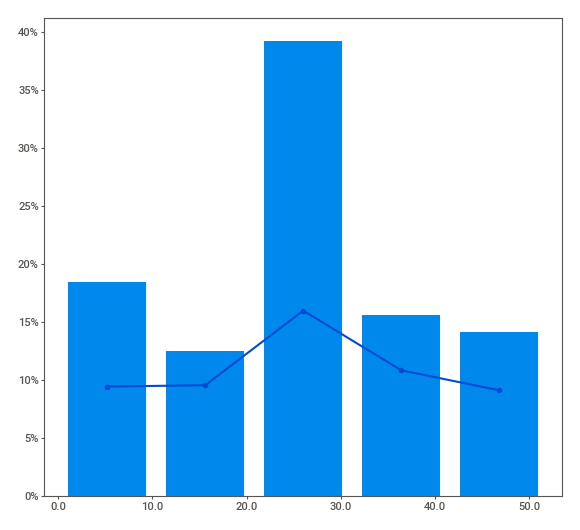
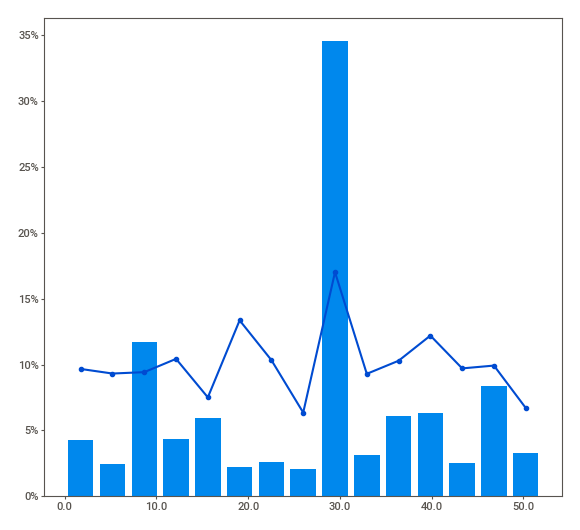
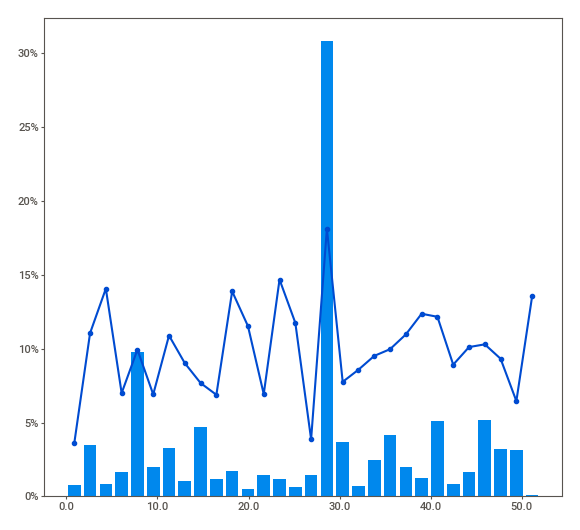
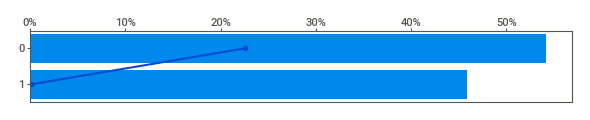
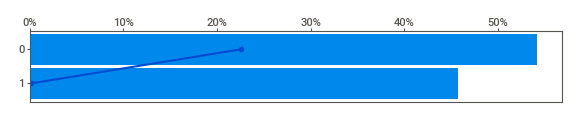
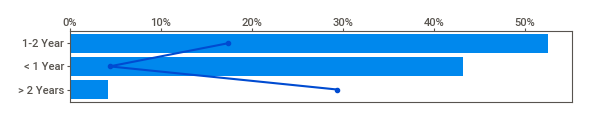
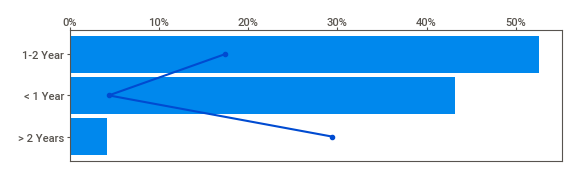
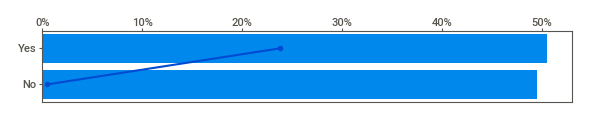
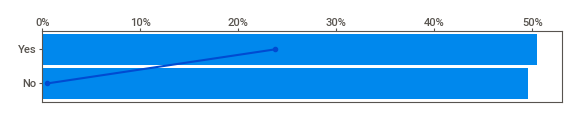
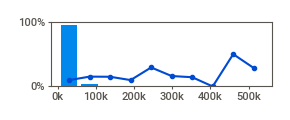
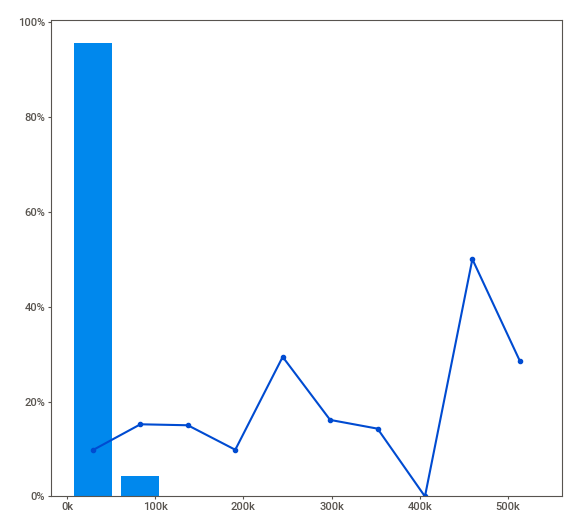
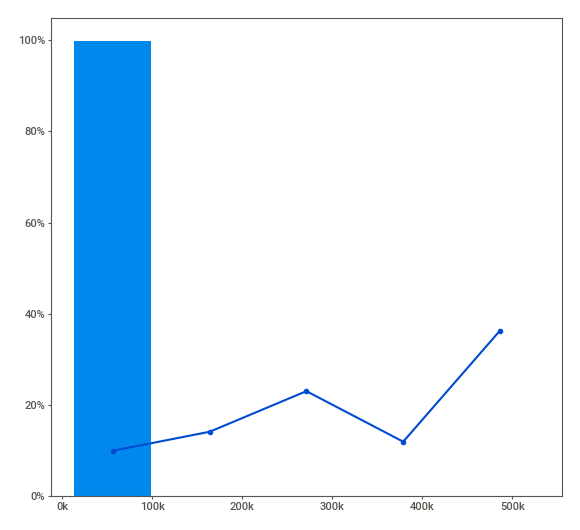
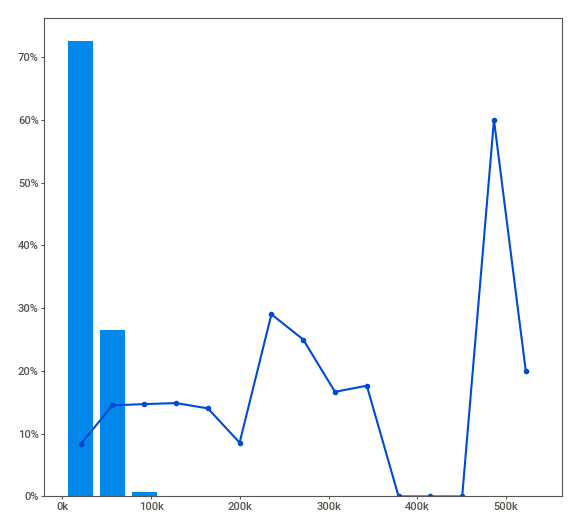
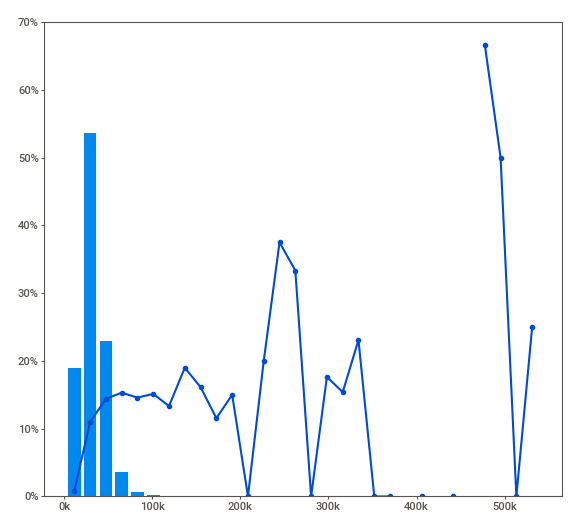
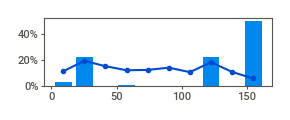
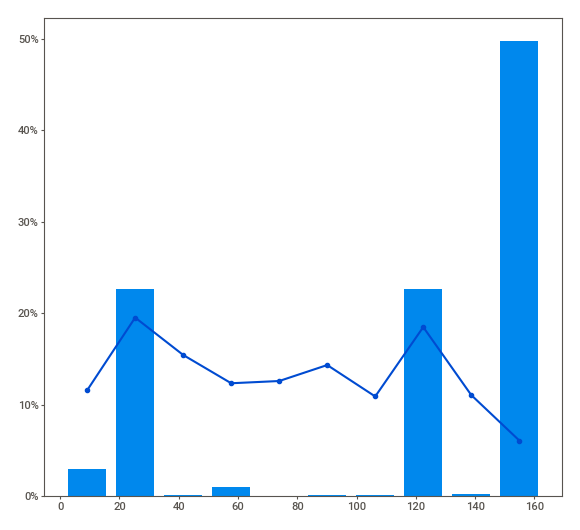
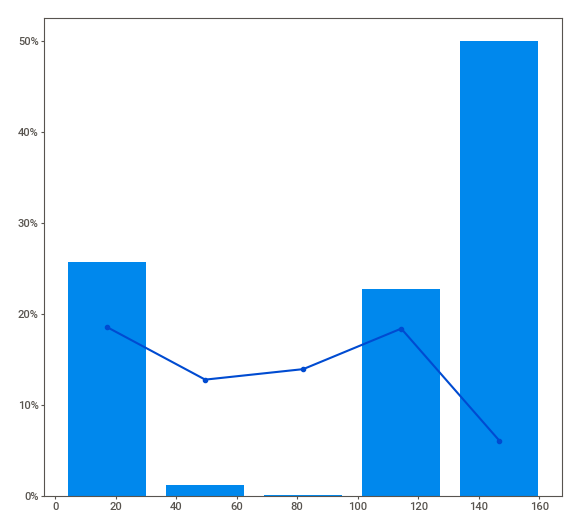
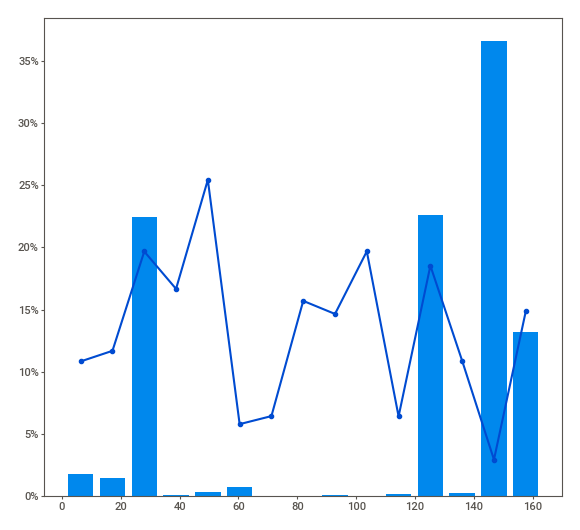
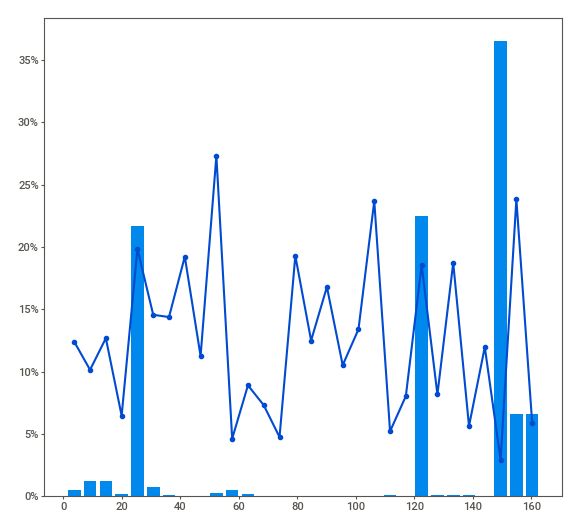
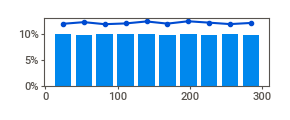
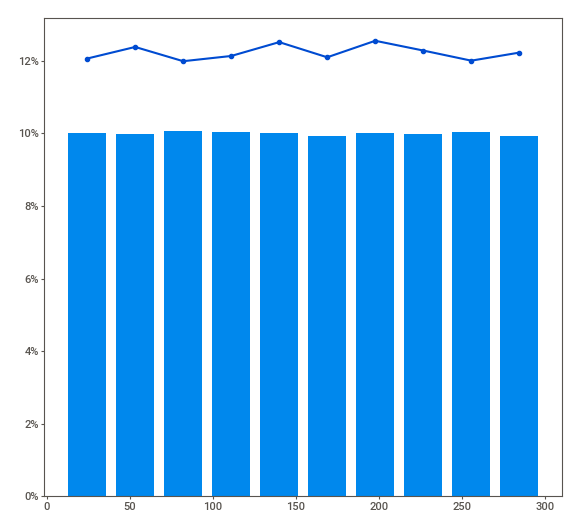
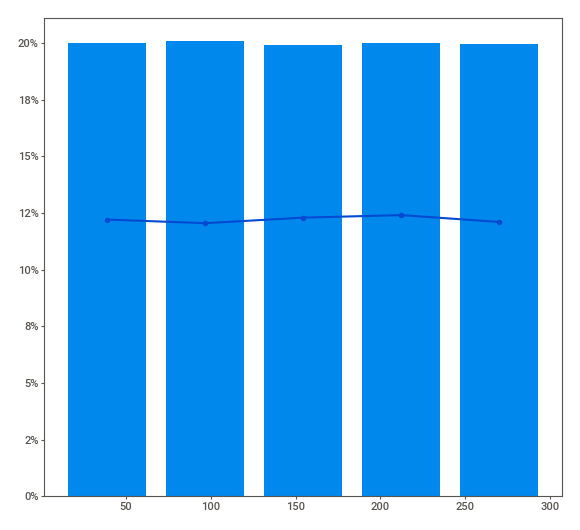
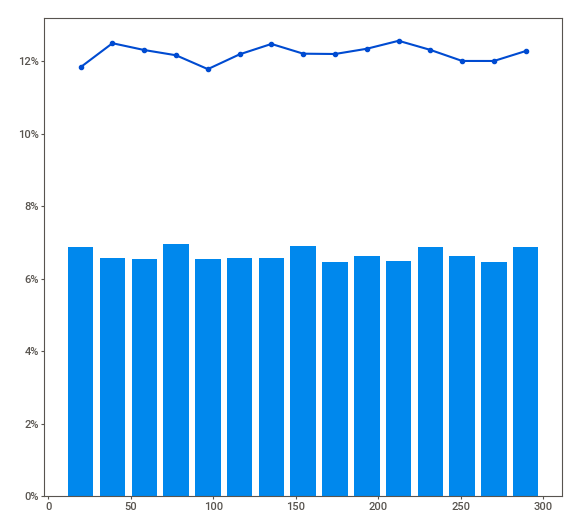
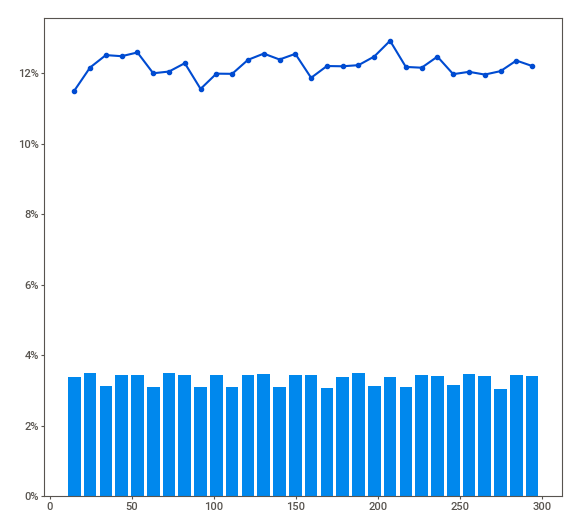
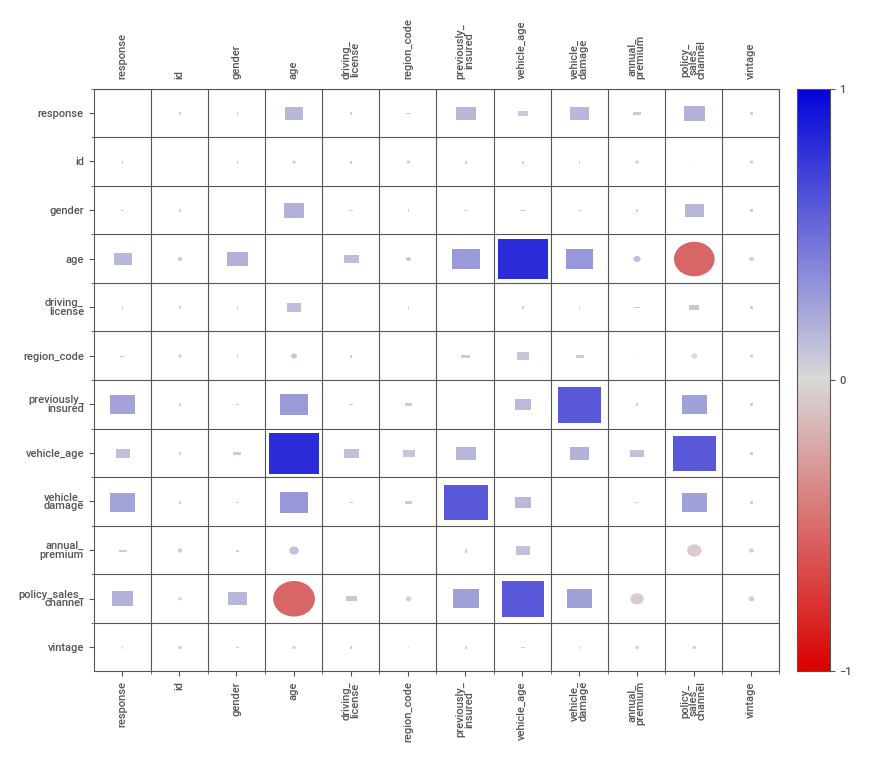
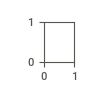

In [38]:
# Display report on notebook
report.show_notebook(w=None, h=None,scale=None,layout='vertical')

### 4.1.1 Numerical Attributes

In [39]:
num_attributes.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

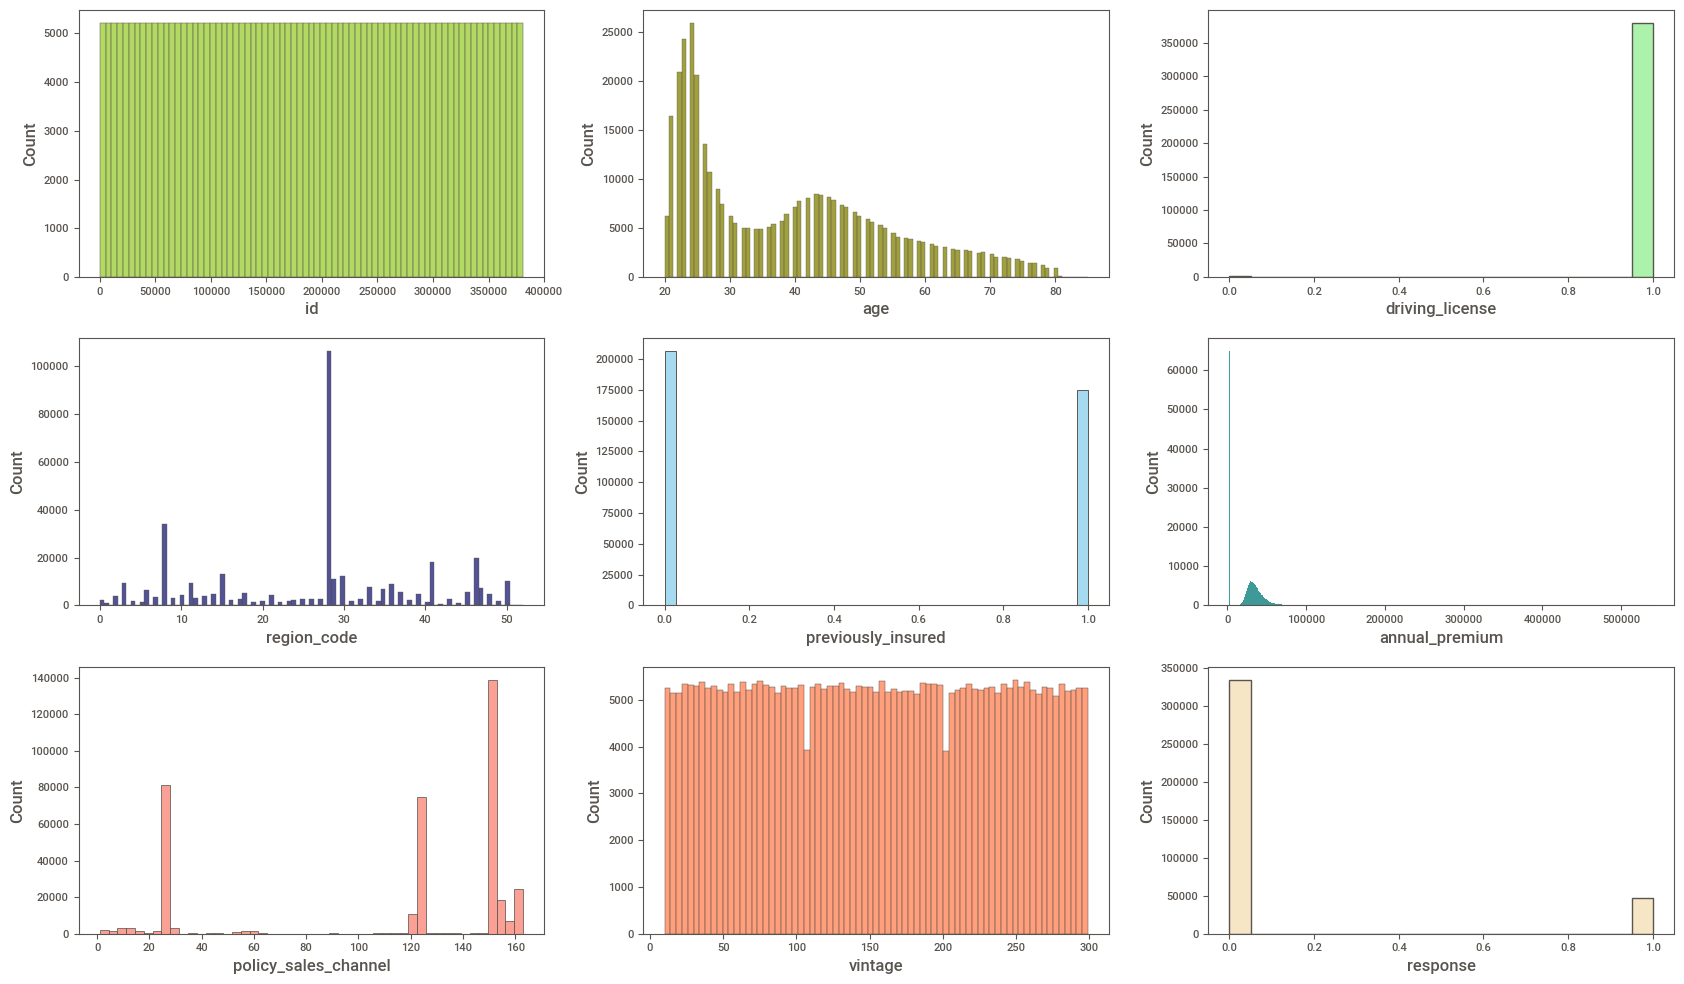

In [40]:
fig, axs = plt.subplots(3, 3, figsize=(17,10))

sns.histplot(data=df4, x=num_attributes.columns[0], kde=False, cbar=True, color="yellowgreen", ax=axs[0, 0])
sns.histplot(data=df4, x=num_attributes.columns[1], kde=False, cbar=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df4, x=num_attributes.columns[2], kde=False, cbar=True, color="lightgreen", ax=axs[0, 2])
sns.histplot(data=df4, x=num_attributes.columns[3], kde=False, cbar=True, color="midnightblue", ax=axs[1, 0])
sns.histplot(data=df4, x=num_attributes.columns[4], kde=False, cbar=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=df4, x=num_attributes.columns[5], kde=False, cbar=True, color="teal", ax=axs[1, 2])
sns.histplot(data=df4, x=num_attributes.columns[6], kde=False, cbar=True, color="salmon", ax=axs[2, 0])
sns.histplot(data=df4, x=num_attributes.columns[7], kde=False, cbar=True, color="coral", ax=axs[2, 1])
sns.histplot(data=df4, x=num_attributes.columns[8], kde=False, cbar=True, color="wheat", ax=axs[2, 2])
cbar=True, 

plt.show()

#### Age

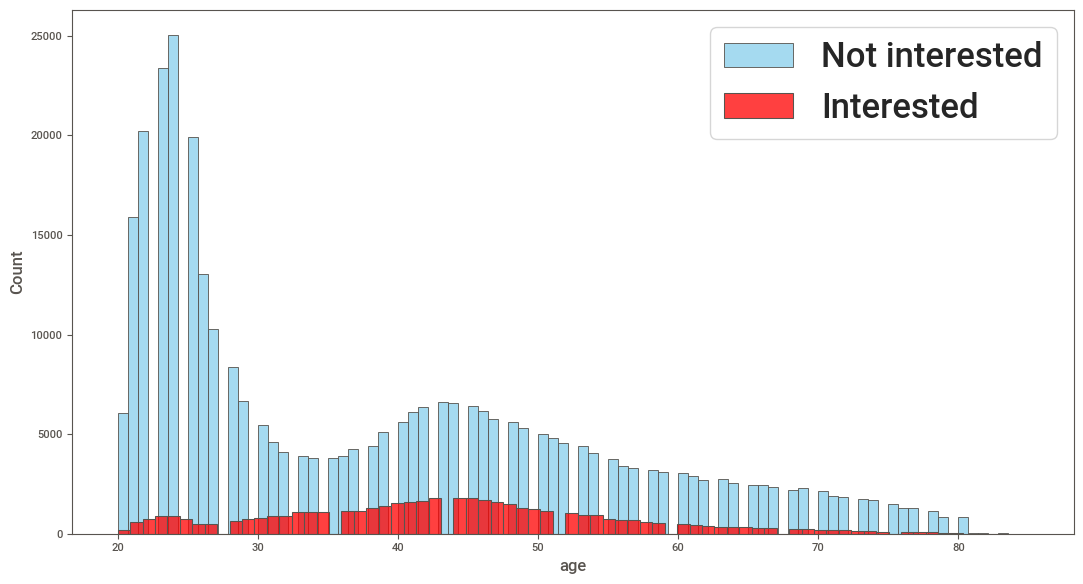

In [41]:
aux10 = df4.loc[df4['response'] == 0, 'age']
aux11 = df4.loc[df4['response'] == 1, 'age']

sns.histplot(data=aux10, color="skyblue", label="Not interested", kde=False)
sns.histplot(data=aux11, color="red", label="Interested", kde=False)
plt.legend(fontsize=25)
plt.show()

#### Driving_license

In [42]:
aux20 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

aux20['driving_license_percentage'] = aux20['driving_license'] / aux20['driving_license'].sum()
aux20

,response,driving_license,driving_license_percentage
0,0,333628,0.877283
1,1,46669,0.122717


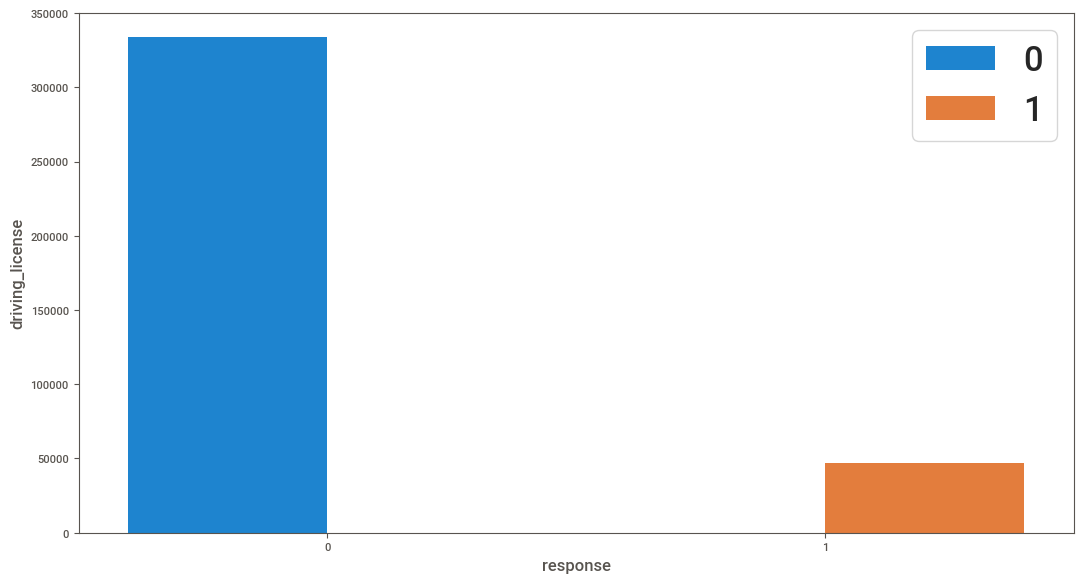

In [43]:
sns.barplot(data=aux20, x='response', y='driving_license', hue='response')
plt.legend(fontsize=25)
plt.show()

#### Region_code

In [44]:
ax30 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

In [45]:
ax30

,region_code,response,id
0,0.0,0,1847
1,0.0,1,174
2,1.0,0,899
3,1.0,1,109
4,2.0,0,3751
...,...,...,...
101,50.0,1,642
102,51.0,0,155
103,51.0,1,28
104,52.0,0,234


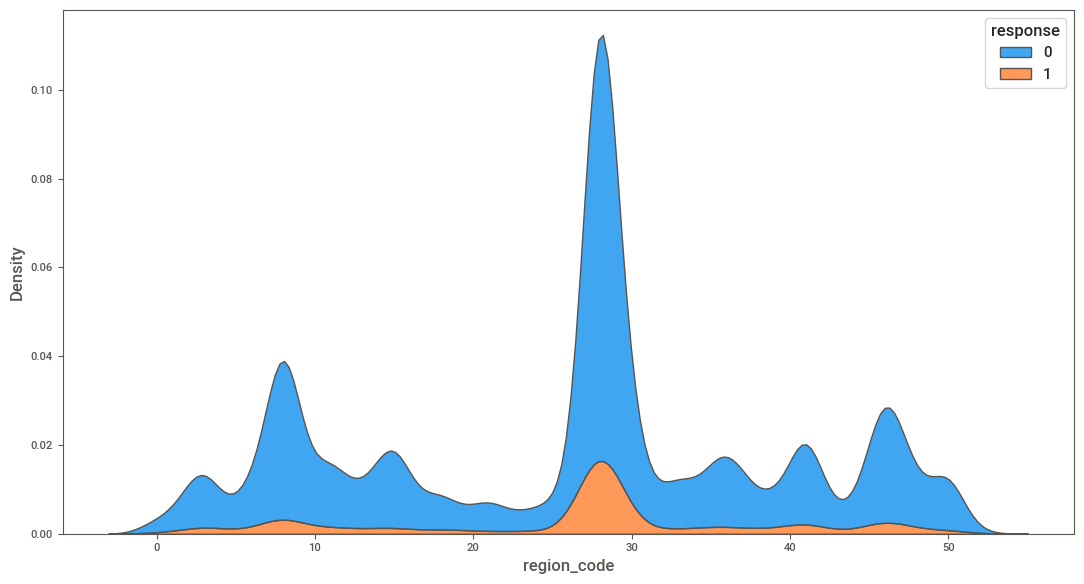

In [46]:
sns.kdeplot(x='region_code',data=df4,hue='response', multiple='stack');

#### Previosuly_insured

In [47]:
# aqui ambas as variáveis são binárias, então devemos usar métrica estatística da frequência
df4[['previously_insured', 'response']].head() 

aux40 = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux40

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


This value is very biased and can cause data leakage to the model: extremely related to the response variable.

#### Vehicle_age

In [48]:
df4[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,1-2 Year,1,0.091328
2,< 1 Year,0,0.413488
3,< 1 Year,1,0.018897
4,> 2 Years,0,0.029663
5,> 2 Years,1,0.012338


In [49]:
aux50 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux50

response,0,1
vehicle_age,,
1-2 Year,0.826245,0.173755
< 1 Year,0.956295,0.043705
> 2 Years,0.706254,0.293746


#### Annual_premium

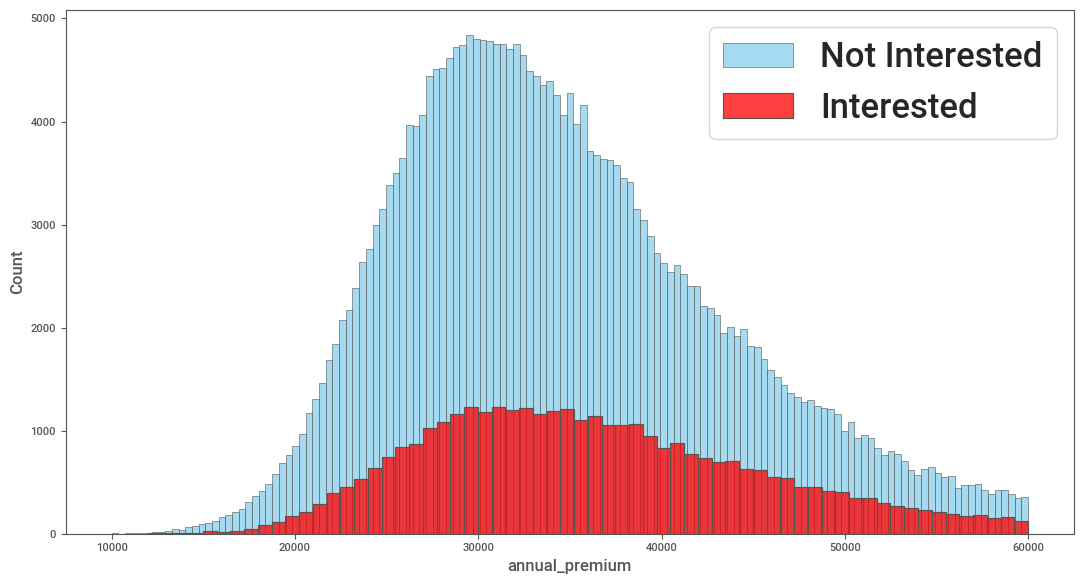

In [50]:
aux70 = df4[(df4['annual_premium'] > 10_000) & (df4['annual_premium'] < 60_000)]
aux71 = aux70.loc[aux70['response'] == 0, 'annual_premium']
aux72 = aux70.loc[aux70['response'] == 1, 'annual_premium']

sns.histplot(data=aux71, color='skyblue', label="Not Interested")
sns.histplot(data=aux72, color='red', label="Interested")
plt.legend(fontsize=25)
plt.show()


#### Policy_sales_channel

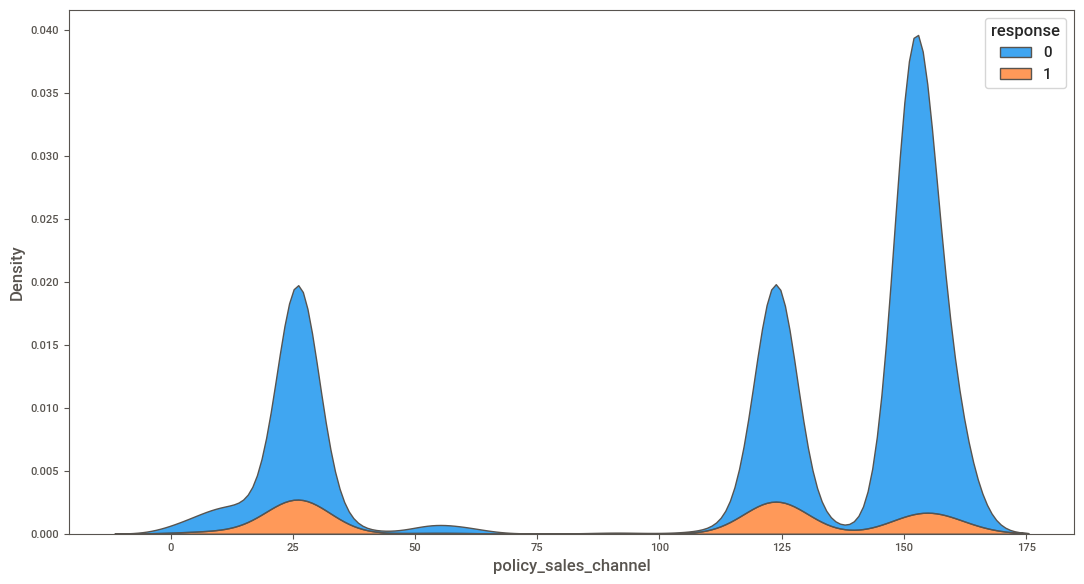

In [51]:
sns.kdeplot(x='policy_sales_channel',data=df4,hue='response',multiple='stack');

#### Vintage

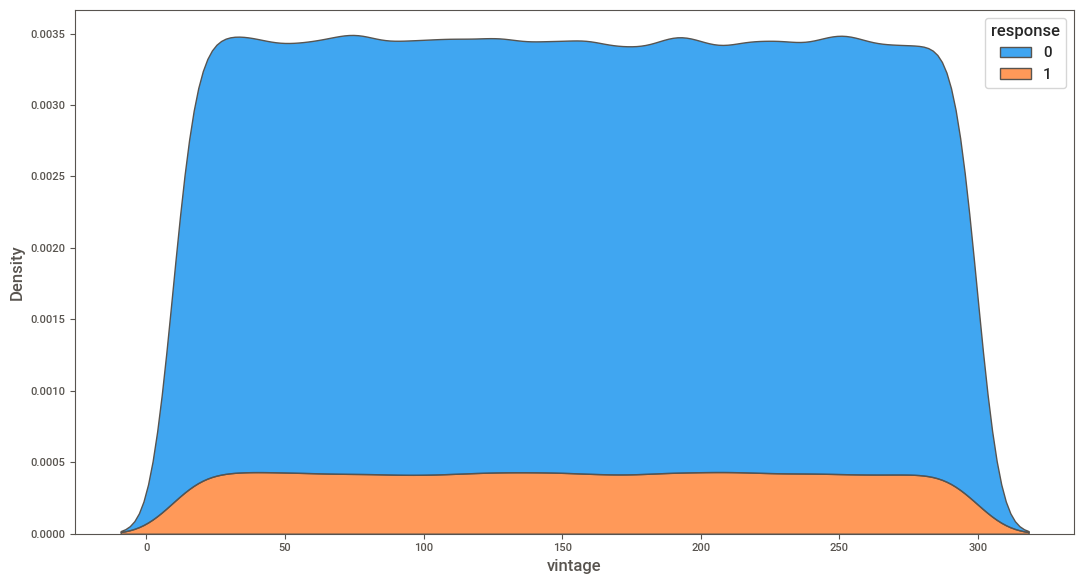

In [52]:
sns.kdeplot(x='vintage',data=df4,hue='response',multiple='stack');

### 4.1.2 Categorical Attributes

In [53]:
# Create function to calculate percentage of values and plot the results
def plot_features(column):
    table_perc = df4.groupby('response')[column].value_counts(normalize = True, sort = False) * 100
    table_perc = table_perc.reset_index(name="percentage")
    
    sns.barplot(x = column, y = 'percentage', hue = 'response', data = table_perc, palette = 'hls')
    labels = [i for i in range(0,105,5)]
    plt.yticks(labels)
    plt.ylabel('% Interested Customers')
    return plt.show()


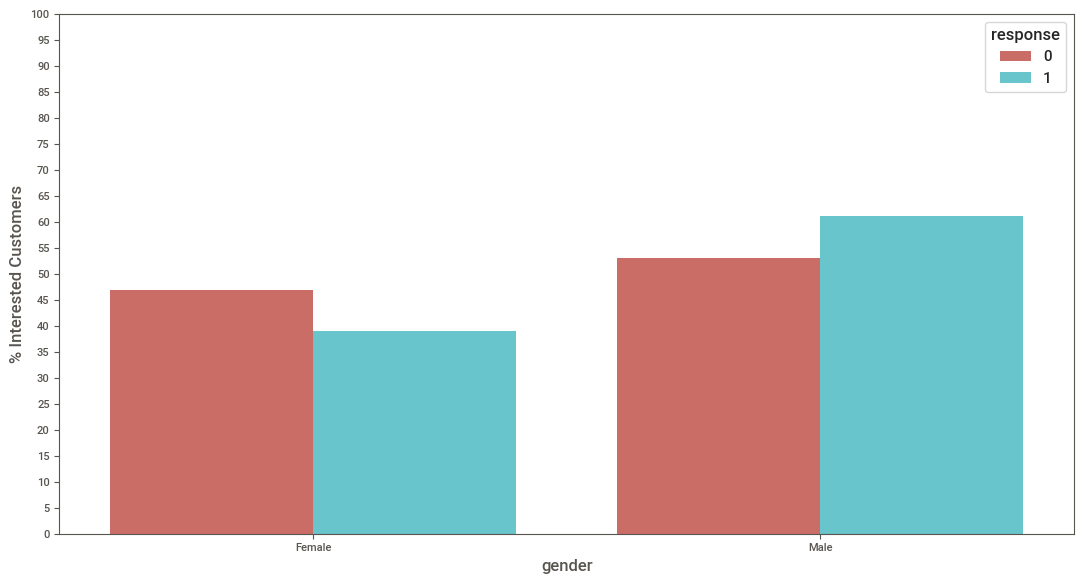

In [54]:
plot_features('gender')

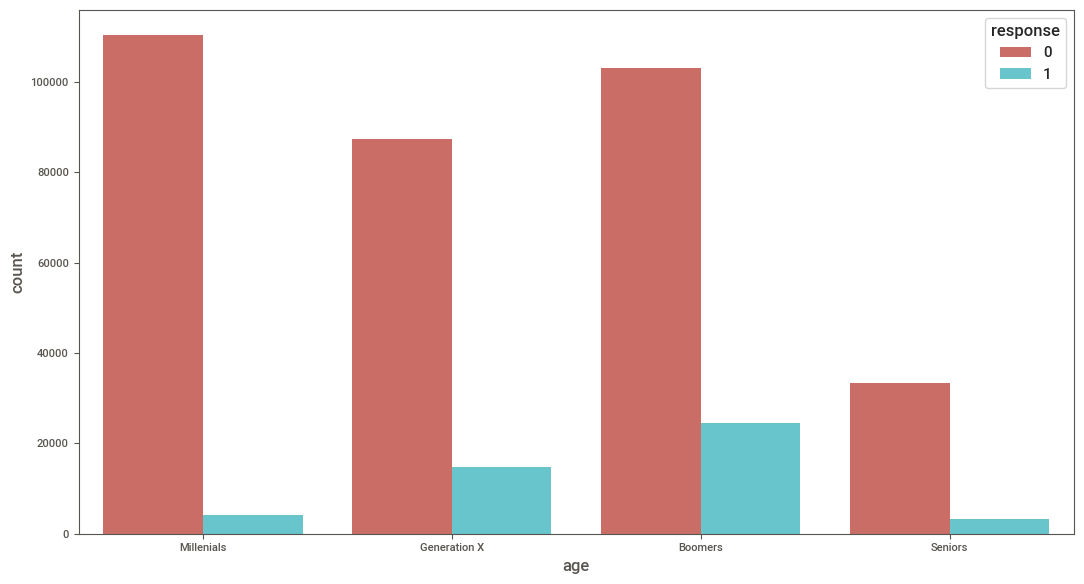

In [55]:
bins=[18, 25, 40, 62, 85]
labels=['Millenials', 'Generation X', 'Boomers', 'Seniors']
biva1 = pd.cut(df4.age, bins=bins, labels=labels)
biva1
# plot_features(biva1)
sns.countplot(x=biva1, data=df4, hue='response', palette='hls');

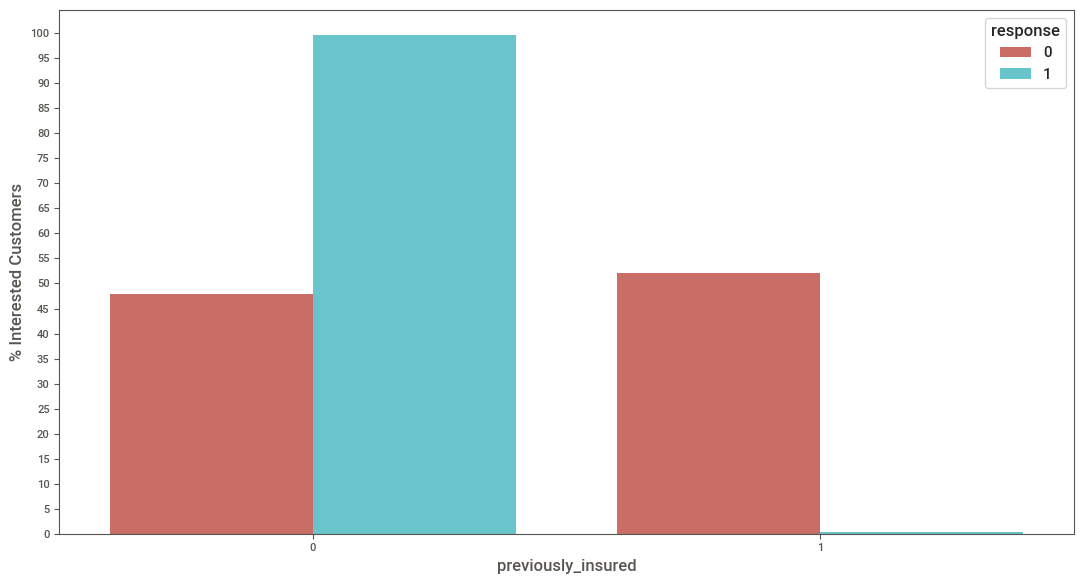

In [56]:
plot_features('previously_insured')

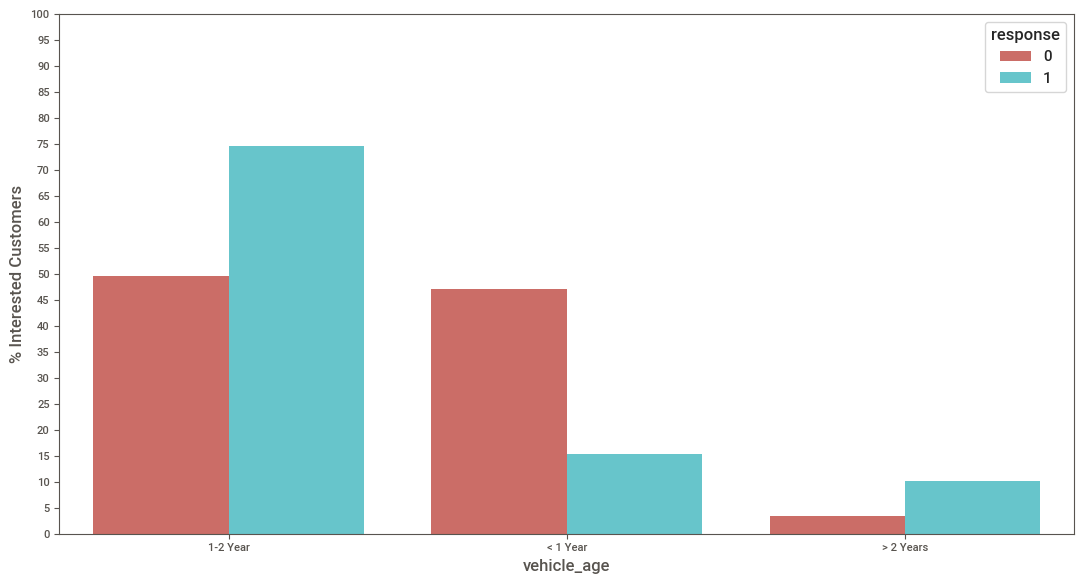

In [57]:
plot_features('vehicle_age')

### 4.1.3 Target Feature

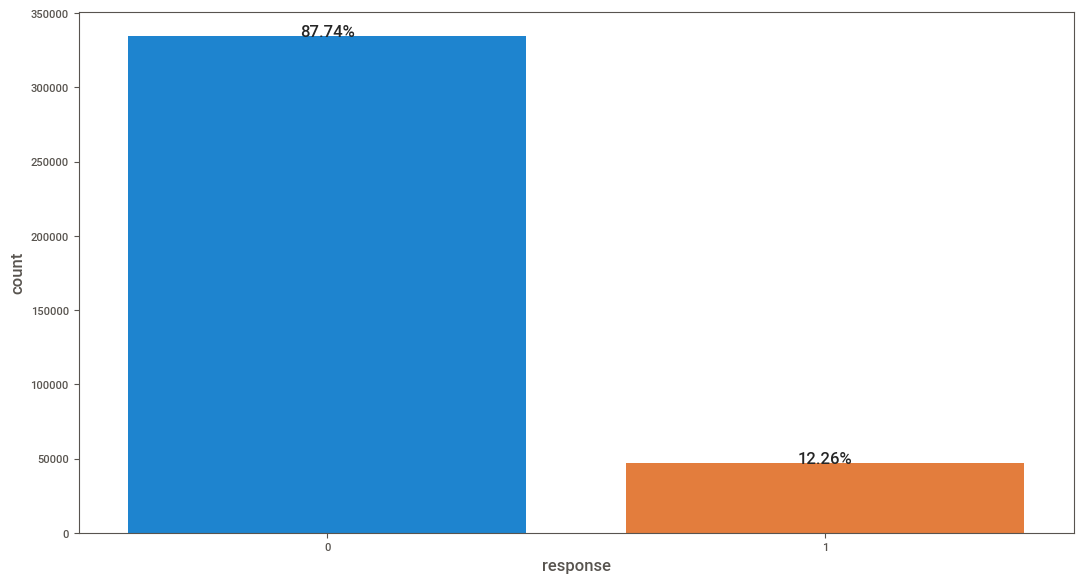

In [58]:
ax=sns.countplot(df4['response'])
total=len(df4['response'])
graphic_percentage(ax,total)

## 4.2. Bivariate Analysis

We will now validate our hypothesis created at **section [2.](#2.0-HYPOTHESIS-CREATION)**.

### H1. Greater interest in FEMALE CUSTOMERS.

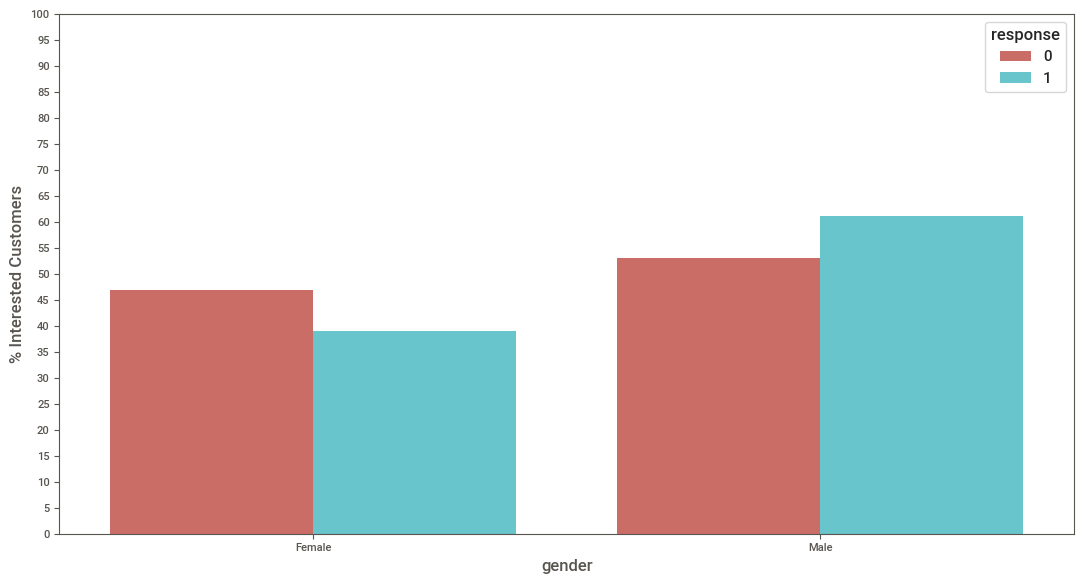

In [59]:
plot_features('gender')

**FALSE** - Male customers have greater of the total interest in getting insurance

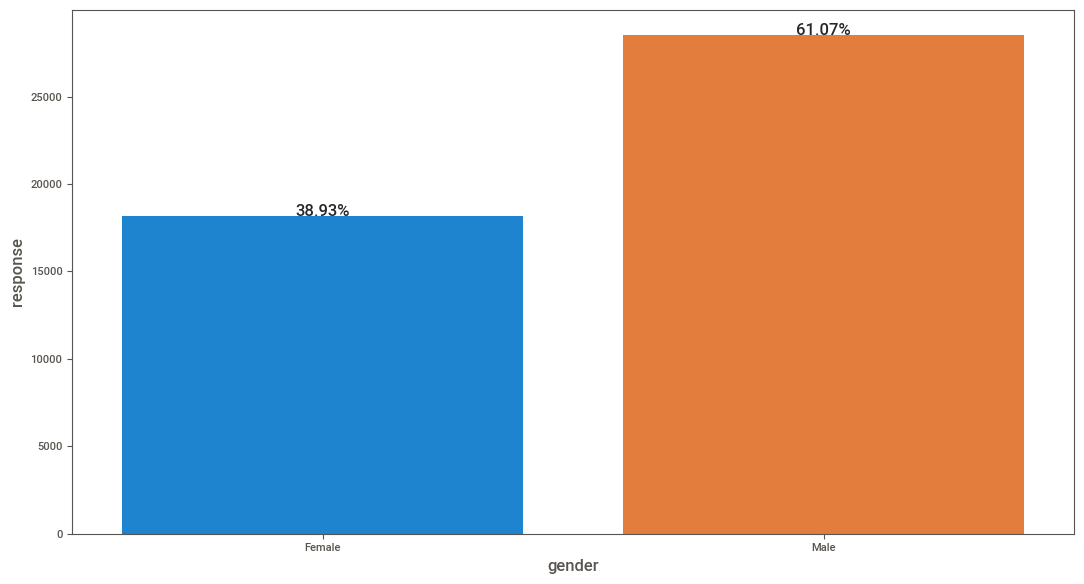

In [60]:
aux = df4[df4['response'] == 1]
aux = aux[['gender','response']].groupby('gender').sum().reset_index()

h1 = sns.barplot(x='gender',y='response',data=aux)
total = sum(aux['response'])

graphic_percentage(h1,total)

### H2. Greater interest in OVER 40 YO CUSTOMERS.

**TRUE**: Customers over 40 years old are the most interested in vehicle insurance.

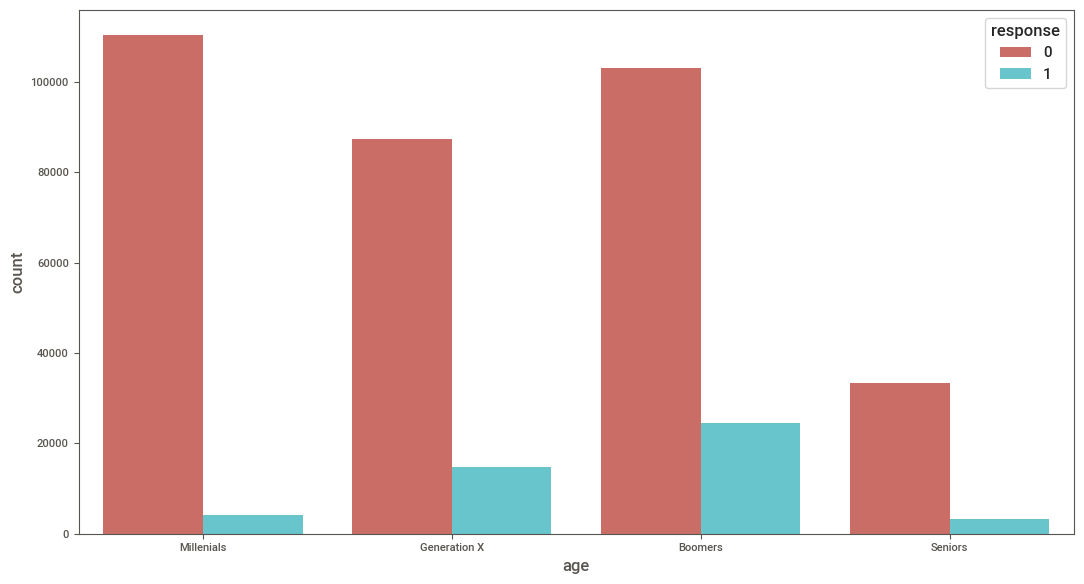

In [61]:
bins=[18, 25, 40, 62, 85]
labels=['Millenials', 'Generation X', 'Boomers', 'Seniors']
biva1 = pd.cut(df4.age, bins=bins, labels=labels)
biva1
# plot_features(biva1)
sns.countplot(x=biva1, data=df4, hue='response', palette='hls');

### H3. Greater interest in URBAN CUSTOMERS.

We don't have info for RURAL/URBAN customers, so we will skip it for now. In next cycle we can further explore region_code.

### H4. Greater interest in LONGER CUSTOMERS

**FALSE**. Interest does not seem to have any correlation with vintage clients.

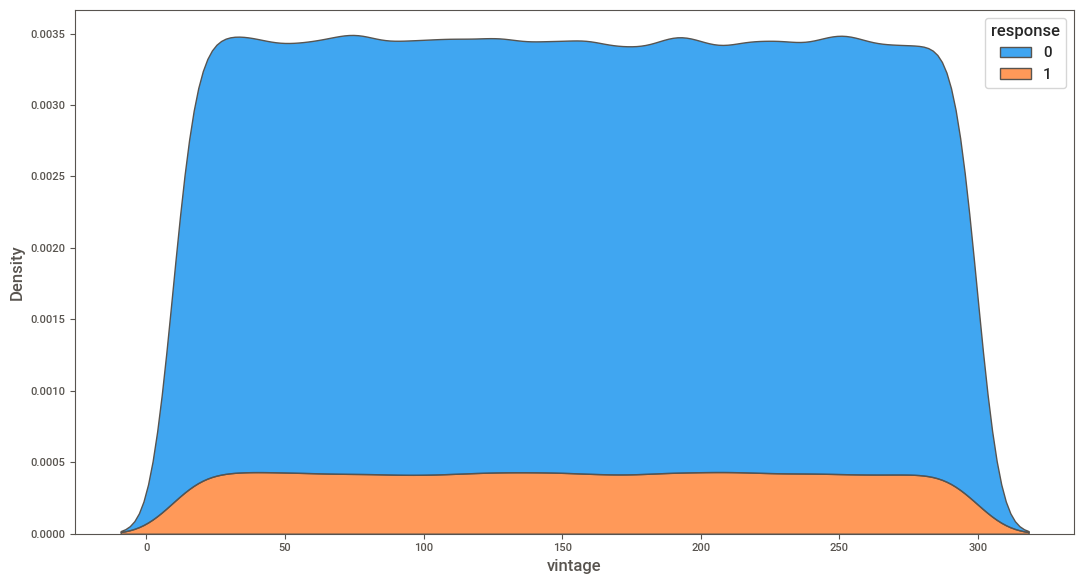

In [62]:
sns.kdeplot(x='vintage',data=df4,hue='response',multiple='stack');

### H5. Greater interest in customers who had VEHICLE PREVIOUSLY DAMAGED

**TRUE**. We can infer that since a client had a previous damage in your vehicle, chances are higher to acquire a insurance.

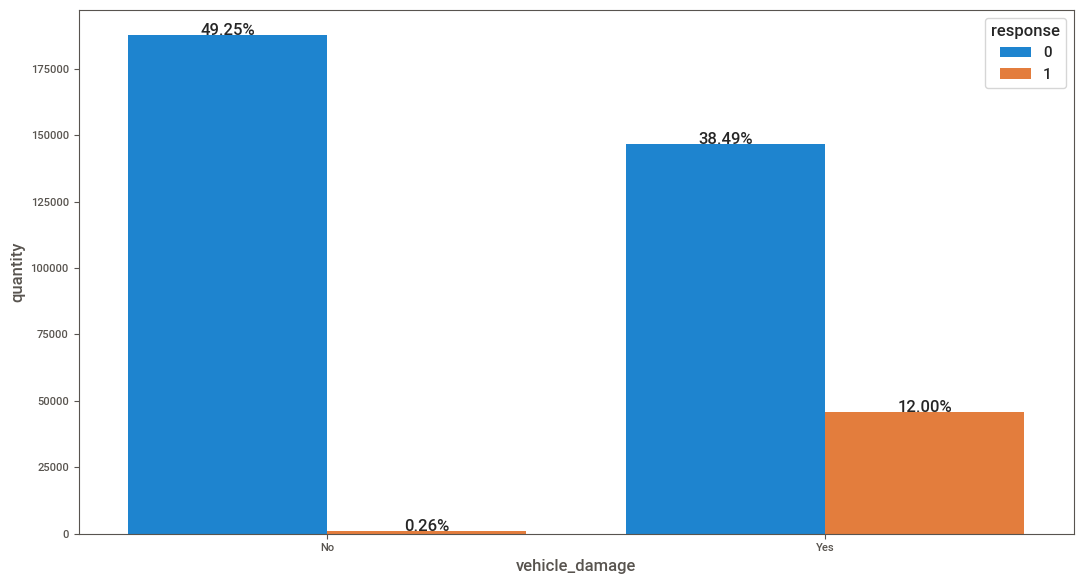

In [63]:
aux = df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'quantity'})
ax = sns.barplot(data=aux, x='vehicle_damage', y='quantity', hue='response');
total=sum(aux['quantity'])
graphic_percentage(ax,total)

### H6. Greater interest in customers who just bought a vehicle (vehicle age).

**FALSE** - Custumers with vehicles between 1 and 2 years are the ones with the most interest in insurance.



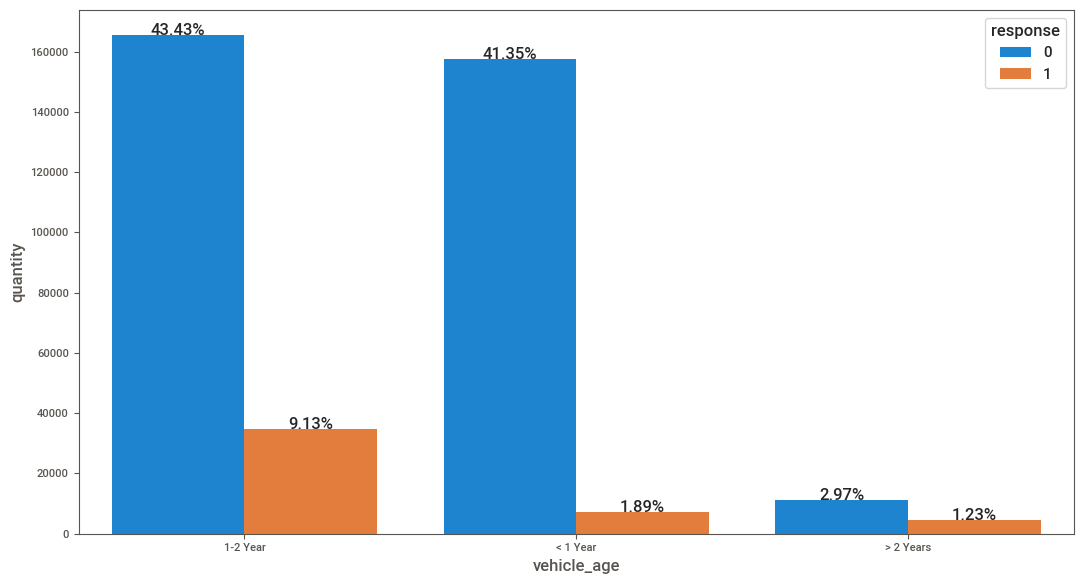

In [64]:
aux = df4[['vehicle_age','response']].groupby(['vehicle_age','response']).size().reset_index().rename(columns={0:'quantity'})

h7 = sns.barplot(x='vehicle_age',y='quantity',hue='response',data=aux)
total = sum(aux['quantity'])
graphic_percentage(h7,total)

## 4.3. Multivariate Analysis

### 4.3.1 Numerical Correlation

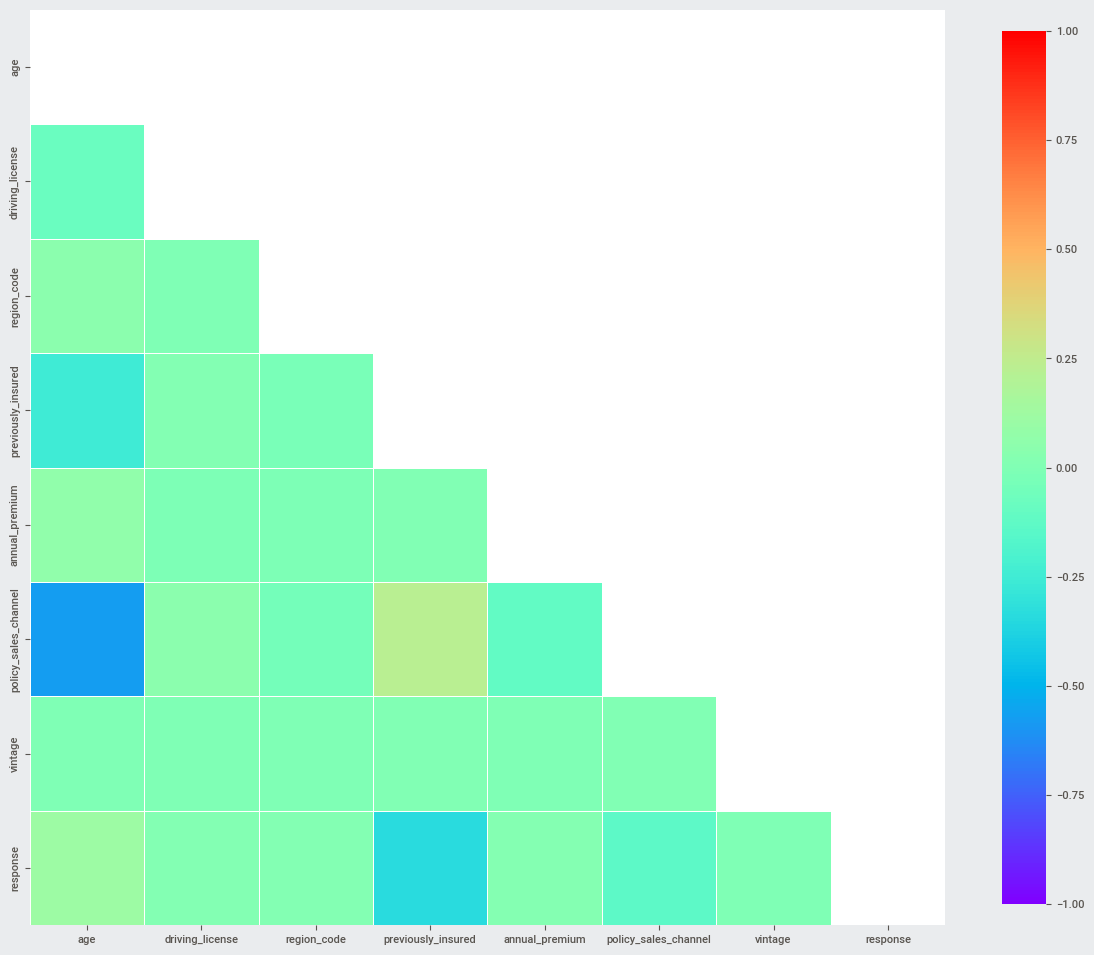

In [65]:
corr = num_attributes.drop('id', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12), facecolor='#EAECEE')
cmap = sns.color_palette("rainbow", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75});

### 4.3.2 Categorical Correlation

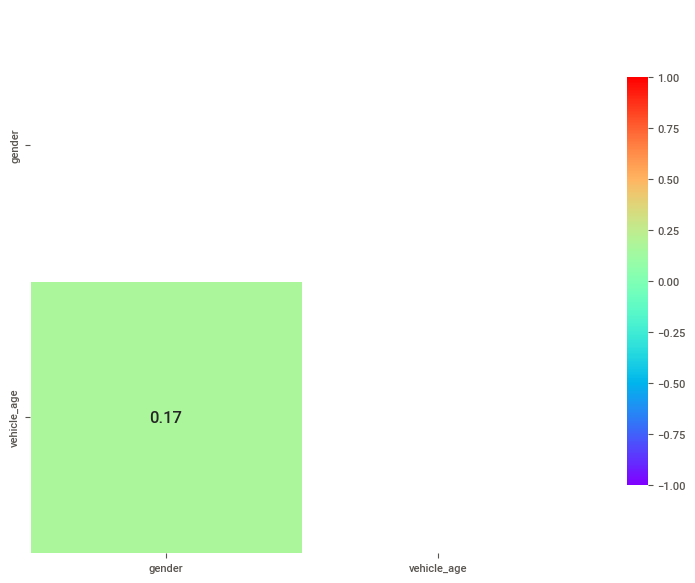

In [66]:
# Only Categorical Attributes
a = df4.select_dtypes(include='object')
a.head()

a1 = cramer_v(a['gender'],a['gender'])
a2 = cramer_v(a['gender'],a['vehicle_age'])

a3 = cramer_v(a['vehicle_age'],a['gender'])
a4 = cramer_v(a['vehicle_age'],a['vehicle_age'])

#Final DataSet
d = pd.DataFrame({'gender':[a1,a2],'vehicle_age':[a3,a4]})
d = d.set_index(d.columns)
d.head()
mask = np.triu(np.ones_like(d, dtype=bool))
sns.heatmap(d, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75});

# 5.0 FEATURE ENGINEERING & DATA PREPARATION

In [67]:
df5 = df4.copy()

## 5.0.1 Feature Changing

In [68]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Preprocess 'vehicle_age' (eliminate '<' and '>' signals) and 'vehicle_damage'.

In [69]:
df5.vehicle_age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

We have 3 categories: over 2 years, between 1-2 years and below 1 year.

In [70]:
df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1-2_years' if x == '1-2 Year'
                                                                                           else 'below_1_year')
df5['vehicle_damage'] = df5['vehicle_damage'].replace(['Yes', 'No'], [1, 0])

## 5.1 Standardization

In [71]:
X = df5.drop('response', axis=1)
y = df5['response'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

In [72]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [73]:
mms = MinMaxScaler()

# age
df5['age'] = mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('../src/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)
pickle.dump(mms, open('../src/features/vintage_scaler.pkl', 'wb'))

## 5.3 Encoding

In [74]:
# gender - One Hot Encoding / Target Encoding
# target_encode_gender = df5.groupby('gender')['response'].mean()
# df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
df5 = pd.get_dummies(df5,prefix='gender',columns=['gender'])

# pickle.dump(target_encode_gender, open('../src/features/target_encoder_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age - One Hot Encoding / Frequency Encoding / Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel.pkl', 'wb'))

## 5.4 Validation Process

In [75]:
# gender
X_validation = pd.get_dummies(X_validation,prefix='gender',columns=['gender'])

# age
X_validation.loc[:, 'age'] = mms.transform(X_validation[['age']].values)

# region_code
X_validation.loc[:, 'region_code'] = X_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
X_validation.loc[:, 'annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

# policy_sales_channel
X_validation.loc[:, 'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
X_validation.loc[:, 'vintage'] = mms.transform(X_validation[['vintage']].values)

# fillna
X_validation = X_validation.fillna(0)

# 6.0 FEATURE SELECTION

In [76]:
df6 = df5.copy()

## 6.1 Data Preparation

In [77]:
# data preparation
X_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

## 6.2 Features Importance

In [78]:
def feature_importance(model, X_train_n, y_train_n):

    
    # Model Training
    model.fit(X_train_n, y_train_n)
    
    importances = et.feature_importances_
    std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature Ranking:\n")
    df = pd.DataFrame()
    for i, j in zip(X_train_n, et.feature_importances_):
        aux = pd.DataFrame({'feature': i , 'importance': j}, index=[0])
        df = pd.concat([df, aux], axis=0)

    print(df.sort_values('importance', ascending=False))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X_train_n.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
    plt.xticks(range(X_train_n.shape[1]), indices)
    plt.xlim([-1, X_train_n.shape[1]])
    plt.show()



Feature Ranking:

                         feature  importance
0                        vintage    0.272022
0                 annual_premium    0.244937
0                            age    0.168755
0                    region_code    0.107280
0                 vehicle_damage    0.065772
0           policy_sales_channel    0.059910
0             previously_insured    0.056495
0       vehicle_age_below_1_year    0.013815
0  vehicle_age_between_1-2_years    0.006239
0       vehicle_age_over_2_years    0.002518
0                  gender_Female    0.000886
0                    gender_Male    0.000869
0                driving_license    0.000501


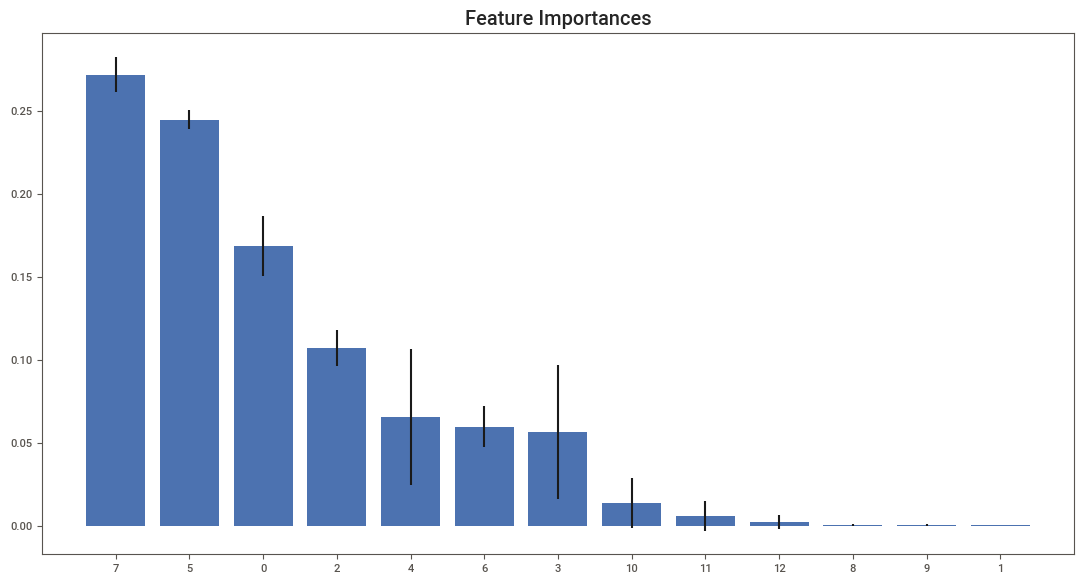

In [79]:
# model definition
et = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# model training and feature importance
feature_importance(et, X_train_n, y_train_n)

# 7.0 MODEL EVALUATION

In [80]:
df7 = df6.copy()

In [81]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 
                'previously_insured', 'policy_sales_channel']

X_train = df5[cols_selected]
X_val = X_validation[cols_selected]
# y_validation = y_validation.copy()

## 7.1 KNN

Model Accuracy: 0.835
ROC AUC Score: 0.7445


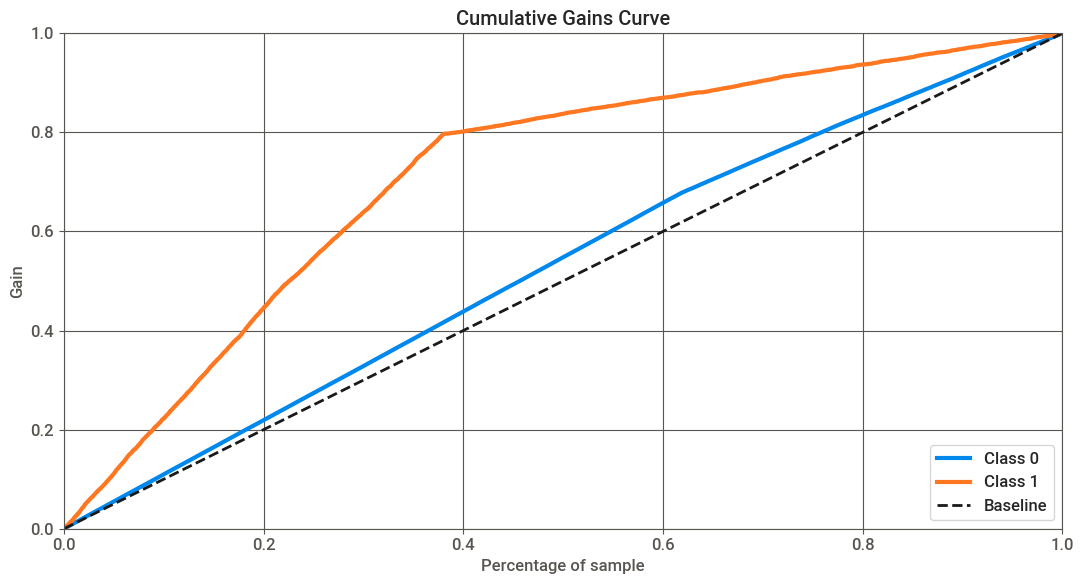

In [82]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train, y_train)

# model prediction - Generalization Power
yhat_knn = knn_model.predict(X_val)
yhat_knn_proba = knn_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_knn):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_knn_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_knn_proba)
plt.show()

## 7.2 Logistic Regression

Model Accuracy: 0.875
ROC AUC Score: 0.8168


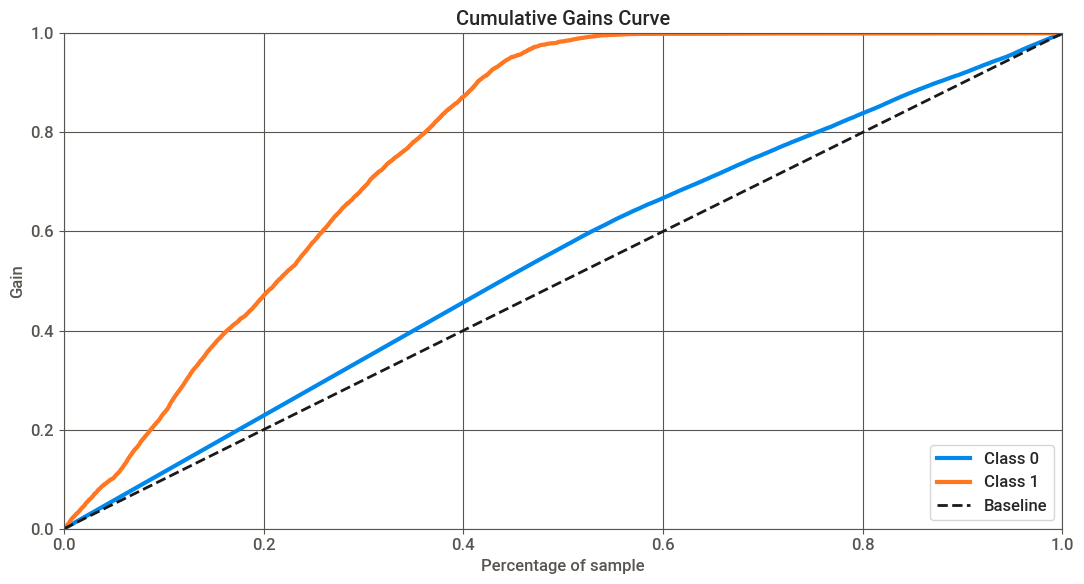

In [83]:
# model definition
logreg_model = LogisticRegression(random_state=42)

# model fit
logreg_model.fit(X_train, y_train)

# model prediction
yhat_logreg = logreg_model.predict(X_val)
yhat_logreg_proba = logreg_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_logreg):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_logreg_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_logreg_proba)
plt.show()

## 7.3 Random Forest

Model Accuracy: 0.847
ROC AUC Score: 0.8123


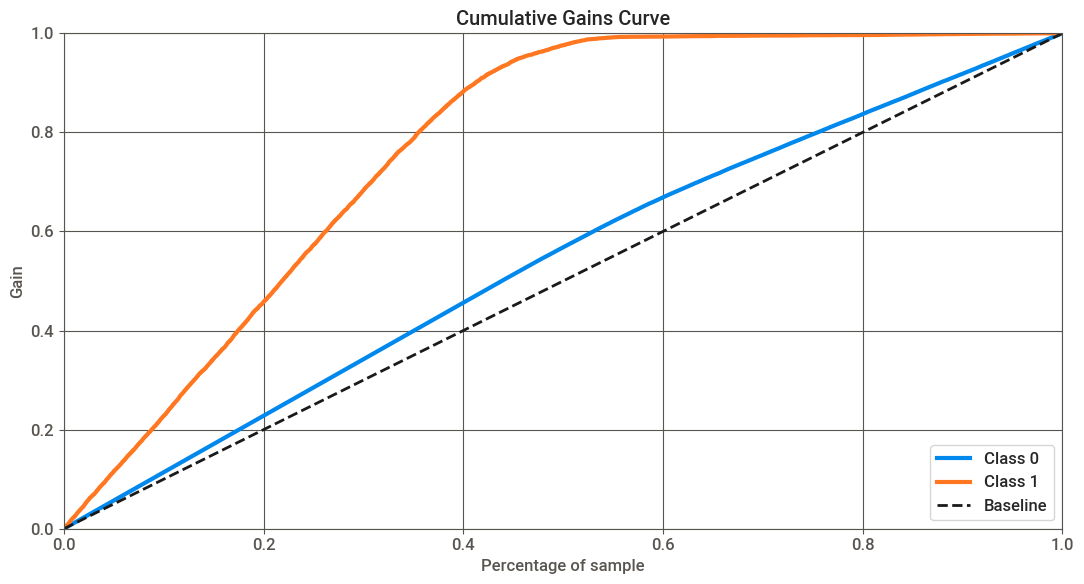

In [84]:

# model definition
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# model fit
rf_model.fit(X_train, y_train)

# model prediction
yhat_rf = rf_model.predict(X_val)
yhat_rf_proba = rf_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_rf):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_rf_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_rf_proba)
plt.show()

## 7.4 XGB

Model Accuracy: 0.865
ROC AUC Score: 0.8210


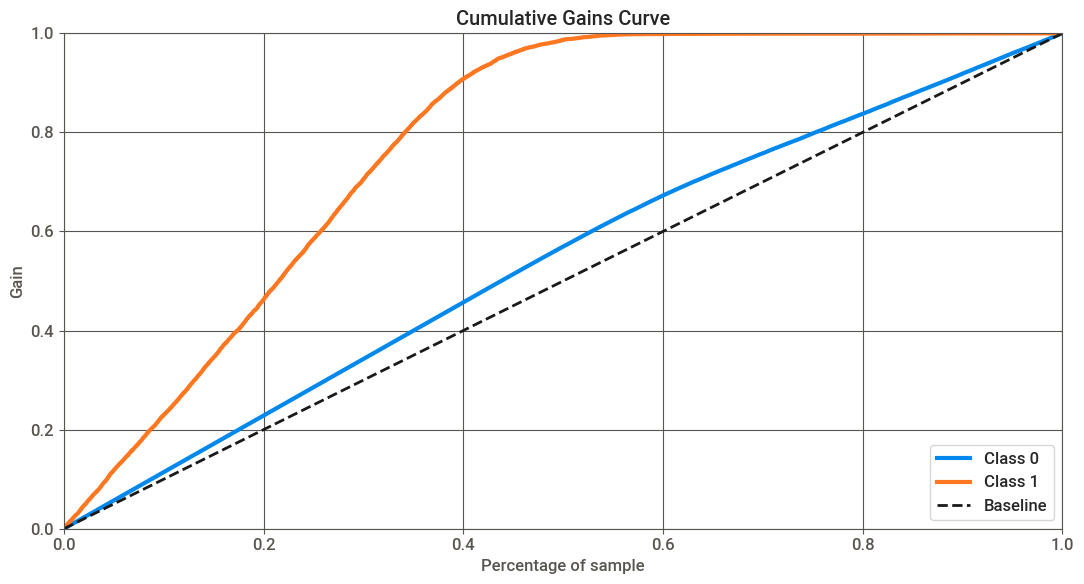

In [85]:
# model definition
xgb_model = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)


# model fit
xgb_model.fit(X_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict(X_val)
yhat_xgb_proba = xgb_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_xgb):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_xgb_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_xgb_proba)
plt.show()

## 7.5 LGBM

Model Accuracy: 0.874
ROC AUC Score: 0.8178


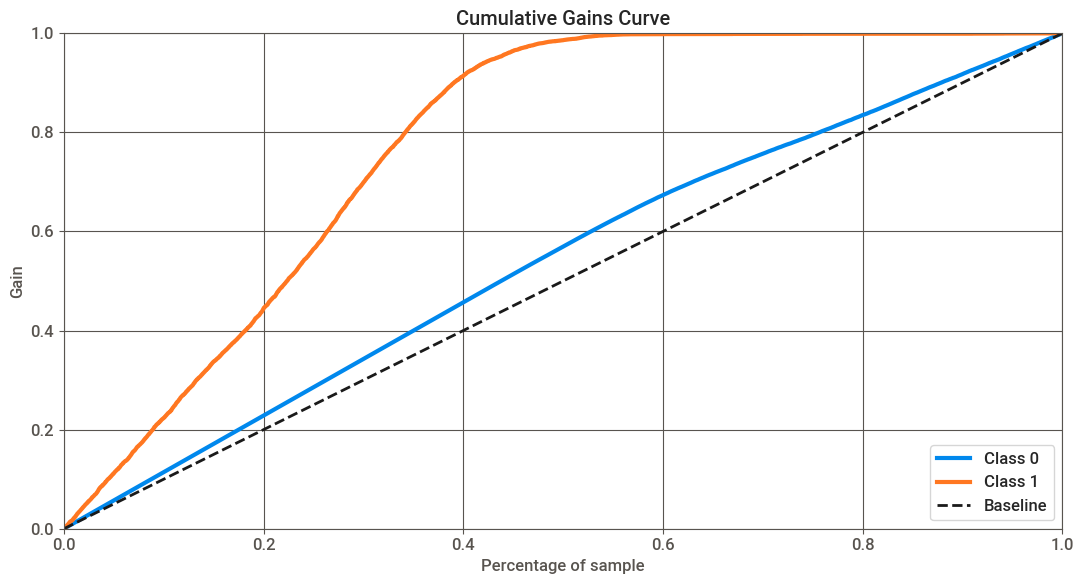

In [86]:
# model definition
lgbm_model = LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1)


# model fit
lgbm_model.fit(X_train, y_train)

# model prediction
yhat_lgbm = lgbm_model.predict(X_val)
yhat_lgbm_proba = lgbm_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_lgbm):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_lgbm_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_lgbm_proba)
plt.show()

## 7.6 Catboost

Model Accuracy: 0.869
ROC AUC Score: 0.8211


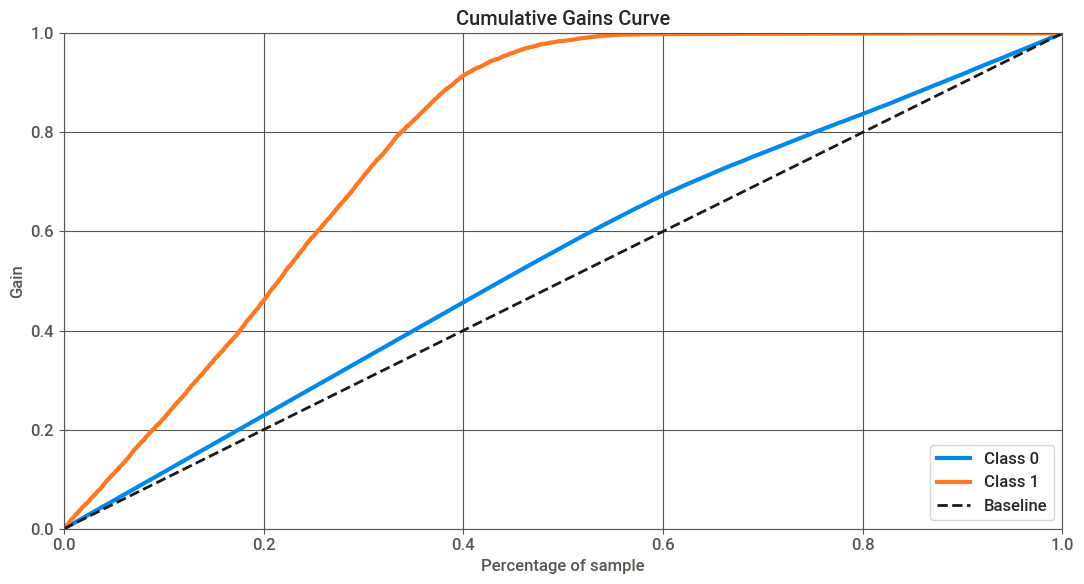

In [87]:
# model definition
ctb_model = CatBoostClassifier(n_estimators=200, random_state=42, verbose=False)


# model fit
ctb_model.fit(X_train, y_train)

# model prediction
yhat_ctb = ctb_model.predict(X_val)
yhat_ctb_proba = ctb_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_ctb):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_ctb_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_ctb_proba)
plt.show()

## 7.7 Naive Bayes

Model Accuracy: 0.64
ROC AUC Score: 0.8132


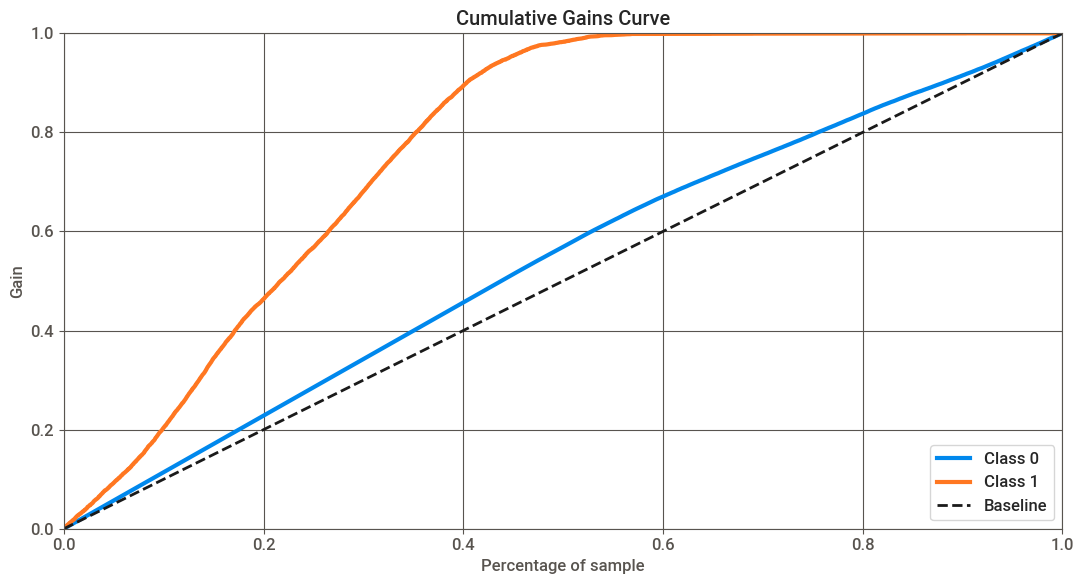

In [88]:
# model definition
nb_model = GaussianNB()


# model fit
nb_model.fit(X_train, y_train)

# model prediction
yhat_nb = nb_model.predict(X_val)
yhat_nb_proba = nb_model.predict_proba(X_val)


# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_validation, yhat_nb):.2f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_validation, yhat_nb_proba[:, 1]):.4f}")


# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_nb_proba)
plt.show()

## 7.8 Model Performance

In [241]:
knn_cv = cross_validation(knn_model,  X_train, y_train, 5, verbose=False)
lr_cv  = cross_validation(logreg_model,X_train,y_train, 5, verbose=False)
rf_cv  = cross_validation(rf_model,   X_train, y_train, 5, verbose=False)
lgb_cv = cross_validation(lgbm_model, X_train, y_train, 5, verbose=False)
xgb_cv = cross_validation(xgb_model,  X_train, y_train, 5, verbose=False)
ctb_cv = cross_validation(ctb_model,  X_train, y_train, 5, verbose=False)
nb_cv  = cross_validation(nb_model,   X_train, y_train, 5, verbose=False)

In [242]:
model_performance_cv = pd.concat([knn_cv,lr_cv,rf_cv,lgb_cv,xgb_cv,ctb_cv, nb_cv])
model_performance_cv.sort_values('ROC AUC Score', ascending=False)

,Model Name,Accuracy Balanced,Precision @K Mean,Recall @K Mean,ROC AUC Score,Top K Score
0,LGBMClassifier,0.501066,0.307935,0.828112,0.853336,0.877706
0,CatBoostClassifier,0.507893,0.305995,0.822895,0.850966,0.876744
0,XGBClassifier,0.511982,0.305255,0.820905,0.849166,0.876341
0,RandomForestClassifier,0.542660,0.289416,0.778310,0.829445,0.865662
0,GaussianNB,0.783939,0.288646,0.776239,0.825829,0.637886
0,LogisticRegression,0.500000,0.274926,0.739344,0.817501,0.878030
0,KNeighborsClassifier,0.557291,0.268607,0.722349,0.752549,0.856038


*We will choose the model with the best cost-benefit ratio (higher score, lower size, higher speed). The chosen one is **LGBM**.*

# 8.0 HYPERPARAMETER FINE-TUNING

In [75]:
# # copy data
# df8 = X_validation.copy()
# df8['response'] = y_validation.copy()

# # propensity score
# df8['score'] = yhat_knn[:, 1].tolist()

# # sort clients by propensity score
# df8 = df8.sort_values('score', ascending=False)

# # compute Precision at K
# precision_at_50 = precision_at_k(df8, 50)
# recall_at_50 = recall_at_k(df8, 50)
# print(f"Precision at K: {precision_at_50:.5f}\nRecall at K:{recall_at_50:.5f}")

### 8.1 Optuna Fine Tuning

#### 8.1.1 Objective Function

In [147]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [264]:
def lgbm_objective(trial):
    
#     num_leaves = trial.suggest_int('num_leaves')
    max_depth = trial.suggest_int('max_depth', 3, 9)
    min_split_gain = trial.suggest_float('min_split_gain', 0.01,0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 10, 50)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 7)
    subsample = trial.suggest_float('subsample', 0.1, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1)
    n_estimators = trial.suggest_int('n_estimators', 100, 1500)
    
    lgbm = LGBMClassifier(num_leaves= 2**max_depth, 
                          max_depth=max_depth,
                          min_split_gain = min_split_gain,
                          min_child_weight = min_child_weight,
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          colsample_bytree = colsample_bytree,
                          n_estimators = n_estimators).fit(X_train,y_train)

    
#     preds =  lgbm.predict_proba(X_val)[:, 1]
    yhat_lgbm = lgbm.predict(X_val)
    yhat_lgbm_proba = lgbm.predict_proba(X_val)
    
    
    data = X_val.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat_lgbm_proba[:,1].tolist()
    data = data.sort_values('score',ascending=False)

    # TOP K SCORE
    knum = y_validation.value_counts().count()-1
    top_k = top_k_accuracy_score(y_validation, yhat_lgbm,k=knum)

    recall_k_20000 = recall_at_k(data, k=20000)
    
#     # Calculate AUC ROC SCORE 
#     auc_roc = roc_auc_score(y_validation, preds)
    
    
    return recall_k_20000
#     return auc_roc

study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=30);

trial = study.best_trial

# print('Best Trial: ', str(study.best_trial)[12:22])
print('Best Recall Score: {}'.format(trial.value))
print('Best hyperparam: {}'.format(trial.params))

Best Recall Score: 0.6208127690853723
Best hyperparam: {'max_depth': 8, 'min_split_gain': 0.026051703134287063, 'min_child_weight': 39, 'min_child_samples': 5, 'subsample': 0.6588357118578377, 'colsample_bytree': 0.7449673337751979, 'n_estimators': 925}


#### 8.1.2 Convergence Visualization

In [256]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### 8.2 GridSearch Fine Tuning

In [152]:
params = {'n_estimators': (10, 50, 100, 200, 500),
          'num_leaves': (5,15,45,60,90),
          'max_depth': (5, 7, 10 ),
          'min_split_gain': (0.001, 0.01 ,0.1),
          'min_child_weight': (10,30,40,50),
          'min_child_weight':(14, 20,30),
          'subsample':(0.5, 0.9),
          'colsample_bytree':(0.1, 1)
         }

In [153]:
%%time

# lgb2 = LGBMClassifier(random_state=42)
# gs = GridSearchCV (lgb2, param_grid=params, cv=5, scoring='roc_auc', verbose=True)
# gs.fit(X_train, y_train)

# roc_auc = roc_auc_score(y_validation, gs.predict(X_validation))

# print(f'ROC: {roc_auc}')
# gs.cv_results_

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
best parameters:  {'colsample_bytree': 1, 'max_depth': 5, 'min_child_weight': 30, 'min_split_gain': 0.1, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 0.5}
best score:  0.85629415224619
CPU times: user 17h 41min 26s, sys: 1min 5s, total: 17h 42min 31s
Wall time: 1h 35min 30s


{'mean_fit_time': array([0.06742754, 0.06431541, 0.07127171, ..., 1.00555406, 1.09192834,
        1.08837934]),
 'std_fit_time': array([0.00405306, 0.00273066, 0.00516044, ..., 0.07149553, 0.1930262 ,
        0.20167312]),
 'mean_score_time': array([0.01467161, 0.01530733, 0.01660242, ..., 0.078654  , 0.07427797,
        0.07813129]),
 'std_score_time': array([0.0003646 , 0.00103542, 0.00092188, ..., 0.00210465, 0.00407485,
        0.00646735]),
 'param_colsample_bytree': masked_array(data=[0.1, 0.1, 0.1, ..., 1, 1, 1],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 5, ..., 10, 10, 10],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[14, 14, 14, ..., 30, 30, 30],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',


### 8.3 Tuned Params

In [204]:
gsbp = gs.best_params_
opbp = trial.params

bp = pd.DataFrame([gsbp])
op = pd.DataFrame([opbp])
bptrans = bp.T
optrans = op.T

tuned_params = pd.concat([bptrans, optrans], axis=1)
tuned_params.columns = ['GridSearch Params', 'Optuna Params']

tuned_params.loc['num_leaves', 'Optuna Params'] = 2 ** aaa.loc['max_depth','Optuna Params']

tuned_params

In [195]:
tuned_params

,GridSearch Params,Optuna Params
colsample_bytree,1.0,0.309829
max_depth,5.0,8.000000
min_child_weight,30.0,42.000000
min_split_gain,0.1,0.020752
n_estimators,200.0,754.000000
num_leaves,15.0,NaN
subsample,0.5,0.878672
min_child_samples,NaN,2.000000


In [154]:
print("best parameters: ",gs.best_params_)
print("best score: ", gs.best_score_)

best parameters:  {'colsample_bytree': 1, 'max_depth': 5, 'min_child_weight': 30, 'min_split_gain': 0.1, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 0.5}
best score:  0.85629415224619


- GridSearch found us a best score than Optuna, but cost us more time. We will keep the best params of GridSearch because of higher AUC score.

### 8.4 Final Model

In [265]:
"""
Best hyperparam: {'max_depth': 8, 'min_split_gain': 0.026051703134287063, 'min_child_weight': 39, 'min_child_samples': 5, 'subsample': 0.6588357118578377, 'colsample_bytree': 0.7449673337751979, 'n_estimators': 925}
"""

"\nBest hyperparam: {'max_depth': 8, 'min_split_gain': 0.026051703134287063, 'min_child_weight': 39, 'min_child_samples': 5, 'subsample': 0.6588357118578377, 'colsample_bytree': 0.7449673337751979, 'n_estimators': 925}\n"

In [244]:
# lgbm_tuned = LGBMClassifier(n_estimators=200,
#                       max_depth=5,
#                       num_leaves=15,
#                       min_split_gain=0.1, 
#                       min_child_weight=30, 
#                       subsample=0.5, 
#                       colsample_bytree=1).fit(X_train,y_train)

In [89]:
lgbm_tuned = LGBMClassifier(n_estimators=925,
                      max_depth=8,
                      num_leaves=2**8,
                      min_split_gain=0.026051703134287063, 
                      min_child_weight=39, 
                      min_child_samples=5,
                      subsample=0.6588357118578377, 
                      colsample_bytree=0.7449673337751979).fit(X_train,y_train)

In [90]:
lgb_cv = cross_validation(lgbm_tuned, X_train, y_train, 5, verbose=False)
lgb_cv

,Model Name,Accuracy Balanced,Precision @K Mean,Recall @K Mean,ROC AUC Score,Top K Score
0,LGBMClassifier,0.507655,0.307615,0.827252,0.852081,0.877505


# 9.0 BUSINESS PERFORMANCE

## 9.1 Business Questions

**a) *What percentage of customers interested in purchasing a new car insurance will the sales team be able to contact by making 20,000 calls?***

In [290]:
# Percentage of Data
percentage_of_data = 20000 / len(X_validation)
df2, yhat_lgbm_proba = ranking_perfomance(lgbm_tuned,X_val,y_validation,X_validation,20000,rc=True)
print('Data Percentage: {0:.2f}%'.format(percentage_of_data*100))
df2

Recall at k = 20000: 0.6188175994959572
Precision at k = 20000: 0.29463526823658814
Data Percentage: 26.24%


,Model Name,ROC AUC,Top @K Acc
0,LGBMClassifier,0.822395,0.865446


By making 20.000 calls, which correspond to 26.24% of our validation dataset, the sales team would be able to reach 61,88% of people interested in purchasing a new car insurance.

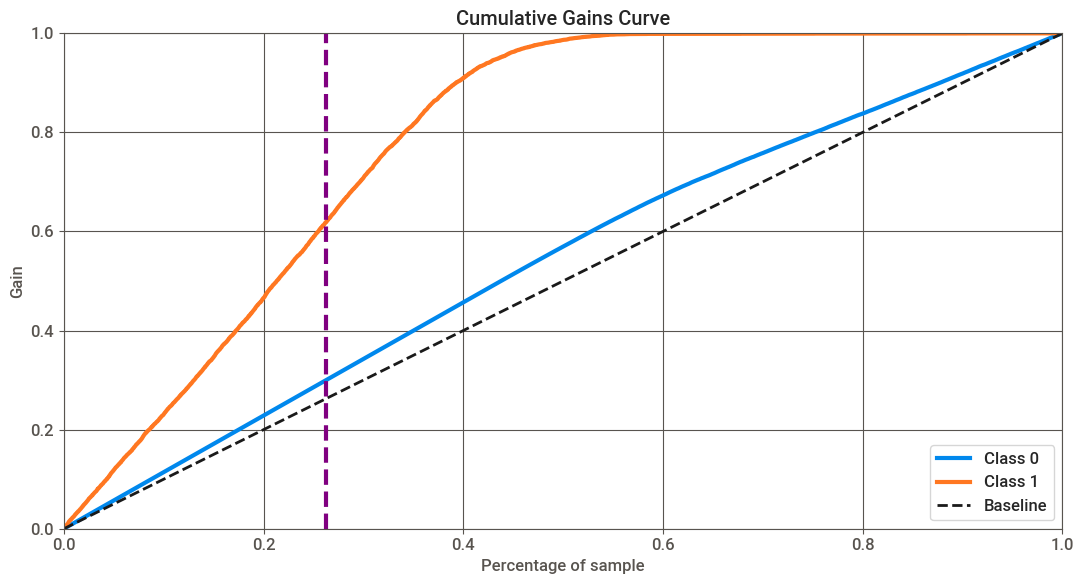

In [291]:
plot_cumulative_gain(y_validation, yhat_lgbm_proba)
plt.axvline(percentage_of_data, 0, 1, color='purple', ls='--', lw=3)
plt.show();

Making 20,000 calls, the model proposed is about 2.35 times better than a random choice (26,24%)

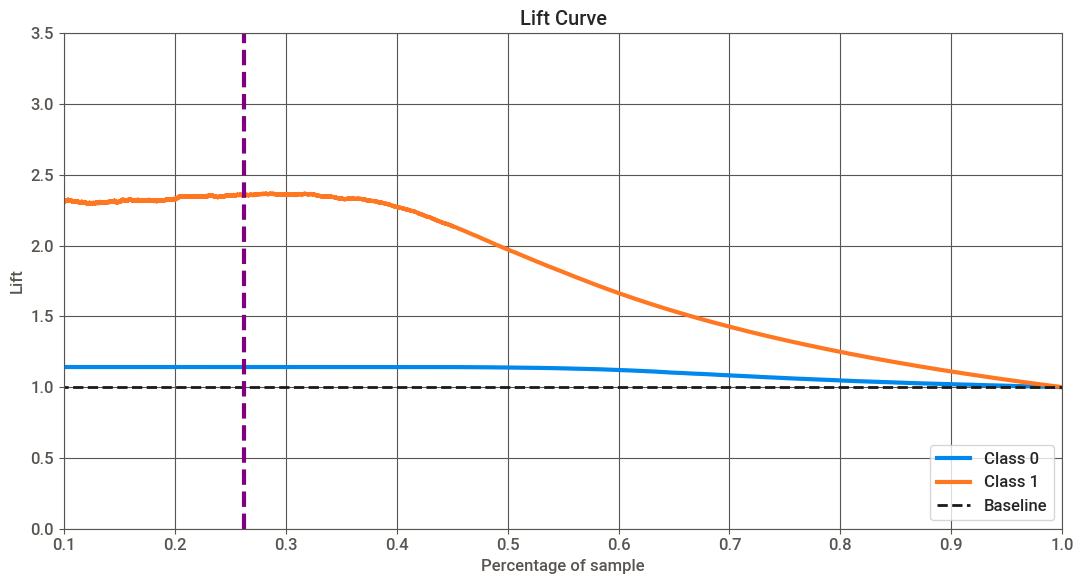

In [292]:
plot_lift_curve(y_validation, yhat_lgbm_proba)
plt.axvline(percentage_of_data, 0, 1, color='purple', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3.5);

**b) *Let's increase the calls to 40,000. What's the new percentage of customers?***

In [293]:
# Percentage of Data
percentage_of_data = 40000 / len(X_validation)
df2, yhat_lgbm_proba = ranking_perfomance(lgbm_tuned,X_val,y_validation,X_validation,40000,rc=True)
print('Data Percentage: {0:.2f}%'.format(percentage_of_data*100))

Recall at k = 40000: 0.9932794287514439
Precision at k = 40000: 0.23646908827279317
Data Percentage: 52.48%


By making 40.000 calls, which correspond to 52.48% of our validation dataset, the sales team would be able to reach 99,33% of people interested in purchasing a new car insurance.

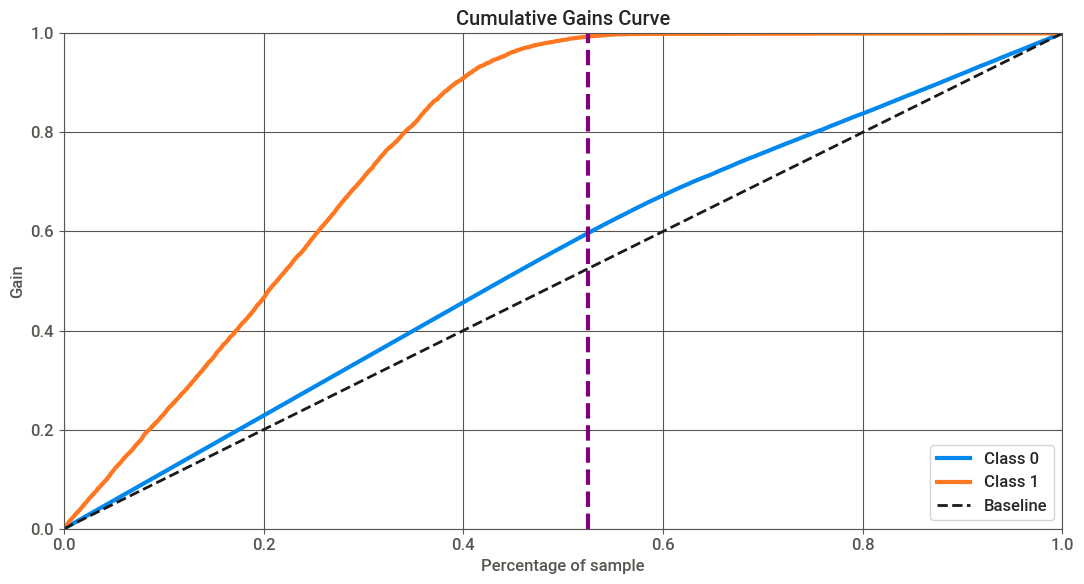

In [294]:
plot_cumulative_gain(y_validation, yhat_lgbm_proba)
plt.axvline(percentage_of_data, 0, 1, color='purple', ls='--', lw=3)
plt.show();

With 40,000 calls, our model is 1.89 times better than a random model.

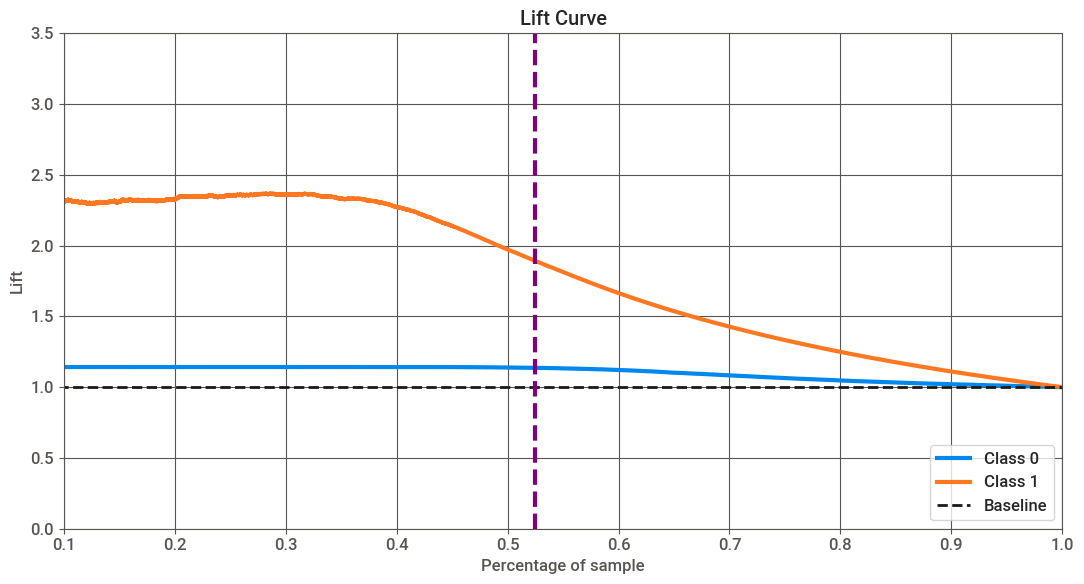

In [295]:
plot_lift_curve(y_validation, yhat_lgbm_proba)
plt.axvline(percentage_of_data, 0, 1, color='purple', ls='--', lw=3);
plt.xlim(0.1,1);
plt.ylim(0,3.5);

**c) *What's the number of calls to reach 80% of interested people?***

In [313]:
# Input the numbers of calls
n = 26010
# Calculate the percentage
percent_of_dataset = int(n) / len (X_validation)

df3, yhat_lgbm_proba = ranking_perfomance(lgbm_tuned, X_val,y_validation, X_validation,int(n),rc=True)
print(f'To make contact to the 80% customers interested in purchasing an auto insurance the sales team needs make {n} calls, which correspond to {percent_of_dataset*100:.2f}% of the validation dataset')

Recall at k = 26010: 0.8001680142812139
Precision at k = 26010: 0.29295298143093307
To make contact to the 80% customers interested in purchasing an auto insurance the sales team needs make 26010 calls, which correspond to 34.12% of the validation dataset


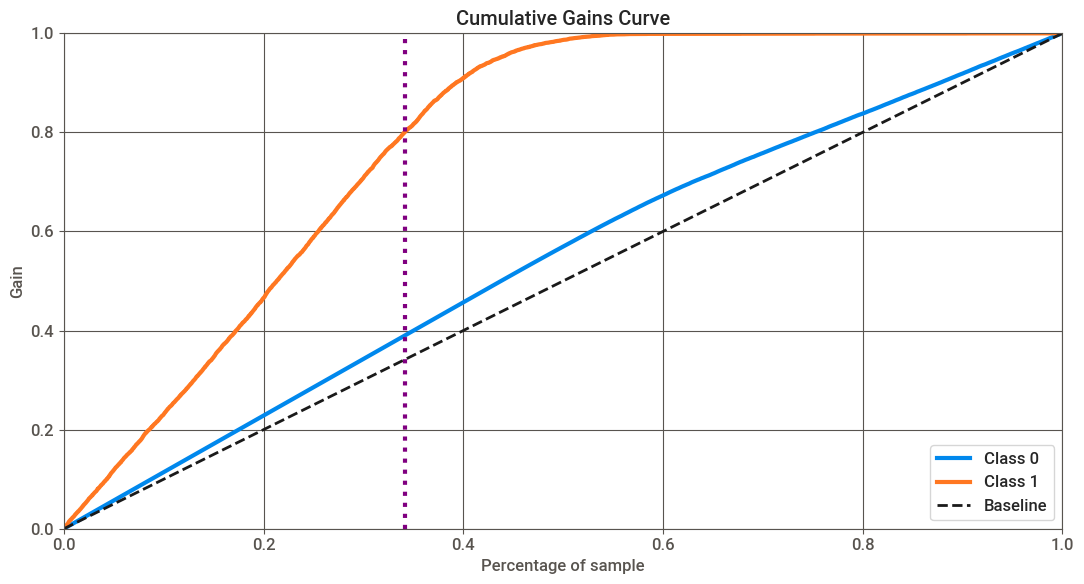

In [314]:
plot_cumulative_gain(y_validation, yhat_lgbm_proba)
plt.axvline(percent_of_dataset, 0, 1, color='purple', ls='dotted', lw=3)
plt.show();

## 9.2 Revenue Business Performance

- So, if we take all the customers from the validation dataset there are in total 76.222 clients. Now we are going to calculate the revenue that would be generated from this dataset according to the requested business questions with the fixed price of an insurance as U$2000,00 per year and not putting in the matter the cost of each call to the company.

- For comparinson purpose we are taking a "random" model representation, which could be a simple ordenation of the list by age or some other specific attribute of the features

PS: This assumptions of values are just fictional and do not translate a real word behavior.

### - 20,000 calls

In [327]:
y_validation.value_counts()

0    66699
1     9523
Name: response, dtype: int64

In [329]:
# For 20.000 calls we reach 71,73% of interested people (response = 1 - which are 9256 customers of 76222 in total.)
# For 20.000 cals with the random model we reach 26% of interested people
random_model = int(np.floor( 0.2624    * y_validation.value_counts()[1]))
lgbm_tuned =  int(np.floor( 0.6188   * y_validation.value_counts()[1]))

print('Number of people reached by Random Model: {} of 9523 with 20.000 calls.'.format(random_model))
print('Number of people reached by Suggested Model: {} of 9523 with 20.000 calls.'.format(lgbm_model))

# Revenue Value per year = 2000
revenue_random = 2000 * random_model 
revenue_model = 2000 * lgbm_model

print('\n')
print('Annual Revenue by Random Model: U$ {:,}'.format(revenue_random))
print('Annual Revenue by Model Suggested: U$ {:,}'.format(revenue_model))
print('Difference between models:U$ {:,}'.format(revenue_model-revenue_random))

Number of people reached by Random Model: 2498 of 9523 with 20.000 calls.
Number of people reached by Suggested Model: 9204 of 9523 with 20.000 calls.


Annual Revenue by Random Model: U$ 4,996,000
Annual Revenue by Model Suggested: U$ 18,408,000
Difference between models:U$ 13,412,000


### - 40,000 calls

In [330]:
# For 40.000 calls we reach 99,47% of interested people (response = 1 - which are 9256 customers of 76222 in total.)
# For 40.000 cals with the random model we reach 52% of interested people
random_model = int(np.floor( 0.5248    * y_validation.value_counts()[1]))
lgbm_model =  int(np.floor( 0.9944   * y_validation.value_counts()[1]))

print('Number of people reached by Random Model: {} of 9523 with 40.000 calls.'.format(random_model))
print('Number of people reached by Suggested Model: {} of 9523 with 40.000 calls.'.format(lgbm_model))

# Revenue Value per year = 2000
revenue_random = 2000 * random_model 
revenue_model = 2000 * lgbm_model

print('\n')
print('Annual Revenue by Random Model: U$ {:,}'.format(revenue_random))
print('Annual Revenue by Model Suggested: U$ {:,}'.format(revenue_model))
print('Difference between models:U$ {:,}'.format(revenue_model-revenue_random))

Number of people reached by Random Model: 4997 of 9523 with 40.000 calls.
Number of people reached by Suggested Model: 9469 of 9523 with 40.000 calls.


Annual Revenue by Random Model: U$ 9,994,000
Annual Revenue by Model Suggested: U$ 18,938,000
Difference between models:U$ 8,944,000


### - 80,000 calls

In [332]:
random_model = int(np.floor( 0.3063    * 9523))
lgbm_model =  int(np.floor( 0.80   * 9523))

print('Number of people reached by Random Model: {} of 9523 with 26,010 calls.'.format(random_model))
print('Number of people reached by Suggested Model: {} of 9523 with 26,010 calls.'.format(lgbm_model))


# Revenue Value per year = 2000
revenue_random = 2000 * random_model 
revenue_model = 2000 * lgbm_model

print('\n')
print('Annual Revenue by Random Model: U$ {:,}'.format(revenue_random))
print('Annual Revenue by Model Suggested: U$ {:,}'.format(revenue_model))
print('Difference between models:U$ {:,}'.format(revenue_model-revenue_random))

Number of people reached by Random Model: 2916 of 9523 with 26,010 calls.
Number of people reached by Suggested Model: 7618 of 9523 with 26,010 calls.


Annual Revenue by Random Model: U$ 5,832,000
Annual Revenue by Model Suggested: U$ 15,236,000
Difference between models:U$ 9,404,000


# 10.0 PRODUCTION DEPLOYMENT

## 10. 1 Test Set Processing

In [91]:
# Training the model with all the data (train+validation)
x_train_final = pd.concat([X_train, X_val],axis=0)
y_train_final = pd.concat([y_train, y_validation],axis=0)

In [16]:
X_test = test.copy()

id_test = X_test['id']

In [17]:
X_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [18]:
X_test.shape

(127037, 11)

In [19]:
# IF customer vehicle was damage in the past -> 1 else ->
X_test['vehicle_damage'] =X_test['vehicle_damage'].apply(lambda x:1 if x == 'Yes' else 0)
# Vehicle_age < 1 Year', '1-2 Year', '> 2 Years'
X_test['vehicle_age'] = X_test['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_year' if x == '1-2 Year' else 'over_2_years')
X_test['gender'] = X_test['gender'].apply(lambda x: x.lower())

In [20]:
annual_premium_scaler = pickle.load(open('../src/features/annual_premium_scaler.pkl', 'rb'))
age_scaler            = pickle.load(open('../src/features/age_scaler.pkl', 'rb'))
vintage_scaler        = pickle.load(open('../src/features/vintage_scaler.pkl', 'rb'))
target_encode_region_code_scaler = pickle.load(open('../src/features/target_encode_region_code_scaler.pkl', 'rb'))
fe_policy_sales_channel_scaler = pickle.load(open('../src/features/fe_policy_sales_channel.pkl', 'rb'))

## annual_premium
X_test['annual_premium'] = annual_premium_scaler.transform(X_test[['annual_premium']].values)


# age
X_test['age'] = age_scaler.transform(X_test[['age']].values)

# vintage
X_test['vintage'] = vintage_scaler.transform(X_test[['vintage']].values)

# gender
X_test = pd.get_dummies(X_test,prefix='gender',columns=['gender'])

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
X_test.loc[:, 'region_code'] = X_test['region_code'].map(target_encode_region_code_scaler)

# vehicle_age - One Hot Encoding / Frequency Encoding / Order Encoding
X_test = pd.get_dummies(X_test, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
X_test.loc[:, 'policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_policy_sales_channel_scaler)

X_test = X_test.fillna(0)

In [21]:
X_test.isna().sum()

id                              0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
gender_female                   0
gender_male                     0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

In [22]:
X_test.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender_female,gender_male,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
0,381110,0.076923,1,0.109796,1,0,0.302196,0.353472,0.148789,0,1,1,0,0
1,381111,0.307692,1,0.186579,0,1,0.184891,0.004211,0.349481,0,1,0,1,0
2,381112,0.415385,1,0.186579,0,1,0.549324,0.193934,0.653979,0,1,0,1,0
3,381113,0.061538,1,0.075355,1,1,0.393188,0.353472,0.612457,0,1,1,0,0
4,381114,0.107692,1,0.186579,1,0,1.653228,0.353472,0.993080,0,1,1,0,0


In [23]:
# Feature Selection
cols_selected = ['annual_premium', 'vintage', 'age', 
                 'region_code', 
                 'vehicle_damage', 
                 'previously_insured', 'policy_sales_channel']

In [141]:
lgbm_final = LGBMClassifier(n_estimators=1200,
                      max_depth=8,
                      num_leaves=2**8,
                      min_split_gain=0.026051703134287063, 
                      min_child_weight=39, 
                      min_child_samples=5,
                      subsample=0.6588357118578377, 
                      colsample_bytree=0.7449673337751979).fit(x_train_final,y_train_final)

pickle.dump(lgbm_final, open('../src/models/lgbm_final.pkl','wb'))

In [142]:
# model prediction
yhat_lgbm = lgbm_final.predict(X_test[cols_selected])
yhat_lgbm_proba = lgbm_final.predict_proba(X_test[cols_selected])

In [143]:
test_new = test.copy()

In [144]:
test_new['score'] = yhat_lgbm_proba[:, 1]
test_new

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53,0.000758
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111,0.354016
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199,0.295103
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187,0.004677
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297,0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56,0.000439
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165,0.397611
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74,0.000240
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265,0.000284


In [145]:
test_new = test_new.sort_values('score', ascending=False)
test_new = test_new.reset_index(drop=True)
test_new['ranking'] = test_new.index + 1

In [146]:
test_new[test_new['ranking'] < 15244 ]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score,ranking
0,465119,Male,29,1,29.0,0,1-2 Year,Yes,59255.0,124.0,156,0.722547,1
1,454851,Female,37,1,35.0,0,1-2 Year,Yes,26106.0,163.0,13,0.683698,2
2,394143,Female,30,1,11.0,0,1-2 Year,Yes,23777.0,155.0,226,0.676137,3
3,496885,Female,29,1,29.0,0,1-2 Year,Yes,30152.0,124.0,93,0.673989,4
4,462364,Male,35,1,30.0,0,1-2 Year,Yes,25822.0,157.0,290,0.669527,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15238,435299,Male,36,1,39.0,0,1-2 Year,Yes,34251.0,124.0,33,0.335935,15239
15239,390639,Male,37,1,8.0,0,1-2 Year,Yes,37589.0,157.0,145,0.335920,15240
15240,386220,Female,52,1,28.0,0,> 2 Years,Yes,2630.0,124.0,299,0.335918,15241
15241,489658,Male,51,1,28.0,0,1-2 Year,Yes,48594.0,26.0,140,0.335914,15242


In [147]:
test_sheets = test_new.head(50)

In [148]:
test_sample = test_new.sample(50)

In [149]:
test_sample

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score,ranking
12513,388455,Female,44,1,28.0,0,1-2 Year,Yes,40002.0,26.0,247,0.351664,12514
46882,387015,Male,80,1,28.0,0,1-2 Year,Yes,63210.0,26.0,219,0.145862,46883
83105,433622,Female,51,1,41.0,1,1-2 Year,No,26924.0,12.0,68,0.000658,83106
21388,461974,Male,48,1,28.0,0,1-2 Year,Yes,32217.0,122.0,237,0.304543,21389
3241,436362,Female,35,1,10.0,0,1-2 Year,Yes,33169.0,124.0,87,0.426948,3242
57633,499056,Female,23,1,13.0,0,< 1 Year,Yes,25014.0,160.0,191,0.066588,57634
35924,408788,Female,53,1,28.0,0,1-2 Year,Yes,51173.0,13.0,124,0.225819,35925
30492,473475,Female,56,1,45.0,0,1-2 Year,Yes,2630.0,124.0,170,0.258261,30493
64937,451148,Female,20,1,15.0,0,< 1 Year,Yes,38063.0,160.0,44,0.022721,64938
15295,431211,Female,41,1,28.0,0,1-2 Year,Yes,37280.0,26.0,277,0.335608,15296


In [102]:
test_sample.to_csv('../src/data/ClientSample.csv')

In [99]:
test_sheets.to_csv('../src/data/First_50_Clients.csv')

## 10.2 HealthInsurance Class

In [131]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance:
    def __init__(self):
        self.home_path = '/home/leassis/repos_wsl/projects/health_insurance/'
        self.annual_premium_scaler            = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler                       = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl', 'rb'))
        self.vintage_scaler                   = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_policy_sales_channel_scaler   = pickle.load(open(self.home_path + 'src/features/fe_policy_sales_channel.pkl', 'rb'))
        
    def data_cleaning(df):
        cols_new = ['id','gender','age','driving_license','region_code','previously_insured','vehicle_age','vehicle_damage','annual_premium','policy_sales_channel','vintage']
        
        # rename
        df.columns = cols_new
        
        return df
        
    def feature_engineering(df):
        # Vehicle Damage Number
        df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        # Vehicle Age
        df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1-2_years'
                                                                             if x == '1-2 Year' else 'below_1_year')
        
        return df
    
    def data_preparation(df):        
        
        ## annual_premium
        df['annual_premium'] = self.annual_premium_scaler.transform(df[['annual_premium']].values)
        
        # age
        df['age'] = self.age_scaler.transform(df[['age']].values)

        # vintage
        df['vintage'] = self.vintage_scaler.transform(df[['vintage']].values)

        # gender
        df = pd.get_dummies(df,prefix='gender',columns=['gender'])
        
        # region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
        df.loc[:, 'region_code'] = df['region_code'].map(self.target_encode_region_code_scaler)

        # vehicle_age - One Hot Encoding / Frequency Encoding / Order Encoding
        df = pd.get_dummies(df, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df.loc[:, 'policy_sales_channel'] = df['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)


        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 
                         'previously_insured', 'policy_sales_channel']
        
        return df[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
            
        # join prediction
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.3 API Handler

In [160]:
import pickle
import pandas as pd
from flask import Flask, request, Response

#from NOME_DA_PASTA.NOME_DO_ARQUIVO_PYTHON import NOME_DA_FUNÇÃO
from healthinsurance.insurance import HealthInsurance 

# loading model
path = 'home/leassis/repos_wsl/projects/health_insurance/'
model = pickle.load(open('../src/models/lgbm_final.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/healthinsurance/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #verifica se existe
        
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else:
            test_json = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)


        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 10.4 API Tester

In [104]:
import requests

In [105]:
# loading test dataset
df_test = X_validation
df_test['response'] = y_validation

In [106]:
df_test = df_test.sample(10)

In [107]:
df_test

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender_Female,gender_Male,vehicle_age_below_1_year,vehicle_age_between_1-2_years,vehicle_age_over_2_years,response
91731,91732,0.044983,1,0.122946,1,0,0.339636,0.353472,0.709343,0,1,1,0,0,0
116031,116032,0.072664,1,0.102960,0,1,-0.370220,0.353472,0.283737,0,1,1,0,0,0
341246,341247,0.069204,1,0.103990,0,0,-1.619422,0.353472,0.224913,1,0,1,0,0,0
189813,189814,0.038062,1,0.121582,1,0,0.406228,0.056874,0.249135,1,0,1,0,0,0
310696,310697,0.044983,1,0.186579,1,0,2.220394,0.353472,0.636678,1,0,1,0,0,0
86364,86365,0.048443,1,0.100127,0,1,-1.619422,0.010050,0.643599,1,0,1,0,0,0
351073,351074,0.221453,1,0.074305,0,1,0.058835,0.209638,0.131488,0,1,0,1,0,0
33903,33904,0.121107,1,0.186579,1,0,0.962846,0.193934,0.743945,1,0,0,1,0,0
28355,28356,0.044983,1,0.061721,1,0,0.675206,0.353472,0.785467,1,0,1,0,0,0
246541,246542,0.051903,1,0.092022,1,0,-1.619422,0.353472,0.719723,1,0,1,0,0,0


In [153]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [158]:
# API Call
# url = 'http://0.0.0.0:5000/predict'
# url = 'https://health-insurance-model.herokuapp.com/predict'
url = 'https://leassis-healthins.herokuapp.com/healthinsurance/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

In [159]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()